# Simulación

1) Simulando una serie de tiempo ARIMA(1,0,2) con tendencia y estacionalidad...


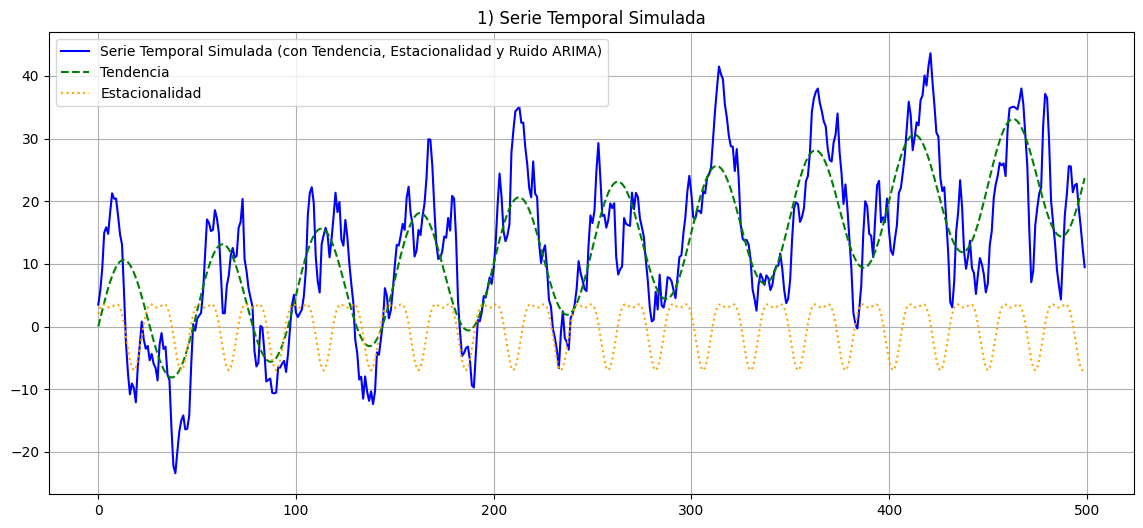


2) Quitando tendencia y estacionalidad usando descomposición STL...
Usando seasonal_param = 25 para STL decomposition.


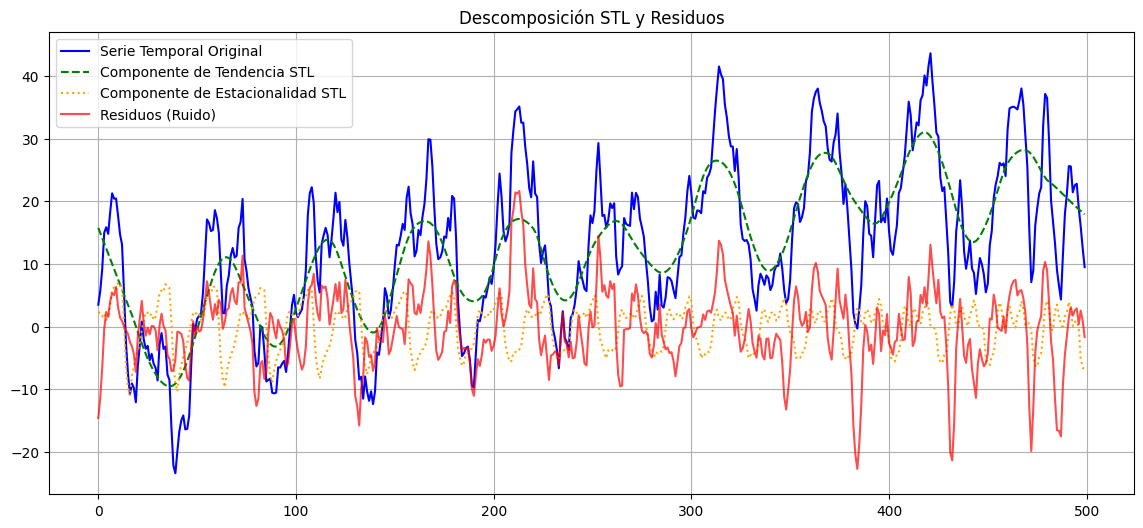


3) Definiendo k grupos Mondrian usando una taxonomía basada en el residuo anterior...
Taxonomía Mondrian (basada en el residuo anterior):
Primeros 10 residuos (sin el primero): [-11.37  -6.48  -0.41   2.34   1.53   4.03   5.3    5.02   6.31   3.08]
Categorías asignadas (sin el primero): [3 3 3 4 2 2 2 2 2 1]
  Categoría 1: 64 residuos
  Categoría 2: 171 residuos
  Categoría 3: 59 residuos
  Categoría 4: 205 residuos

3.5) Revisando la correlación de los residuos dentro de cada grupo y aplicando el test de Ljung-Box...

--- Test de Ljung-Box para TODOS los Residuos (Global, lags=30) ---
       lb_stat      lb_pvalue
30  1220.93431  8.839055e-238
El test de Ljung-Box RECHAZA la hipótesis nula de no autocorrelación. Los residuos globales NO son IID.

--- Test de Ljung-Box por Categoría Mondrian ---
Categoría 1 (n=64, lags=6):
     lb_stat  lb_pvalue
6  25.912537   0.000231
  El test de Ljung-Box RECHAZA la hipótesis nula de no autocorrelación en la Categoría 1. NO son IID.
Categoría 2 (n

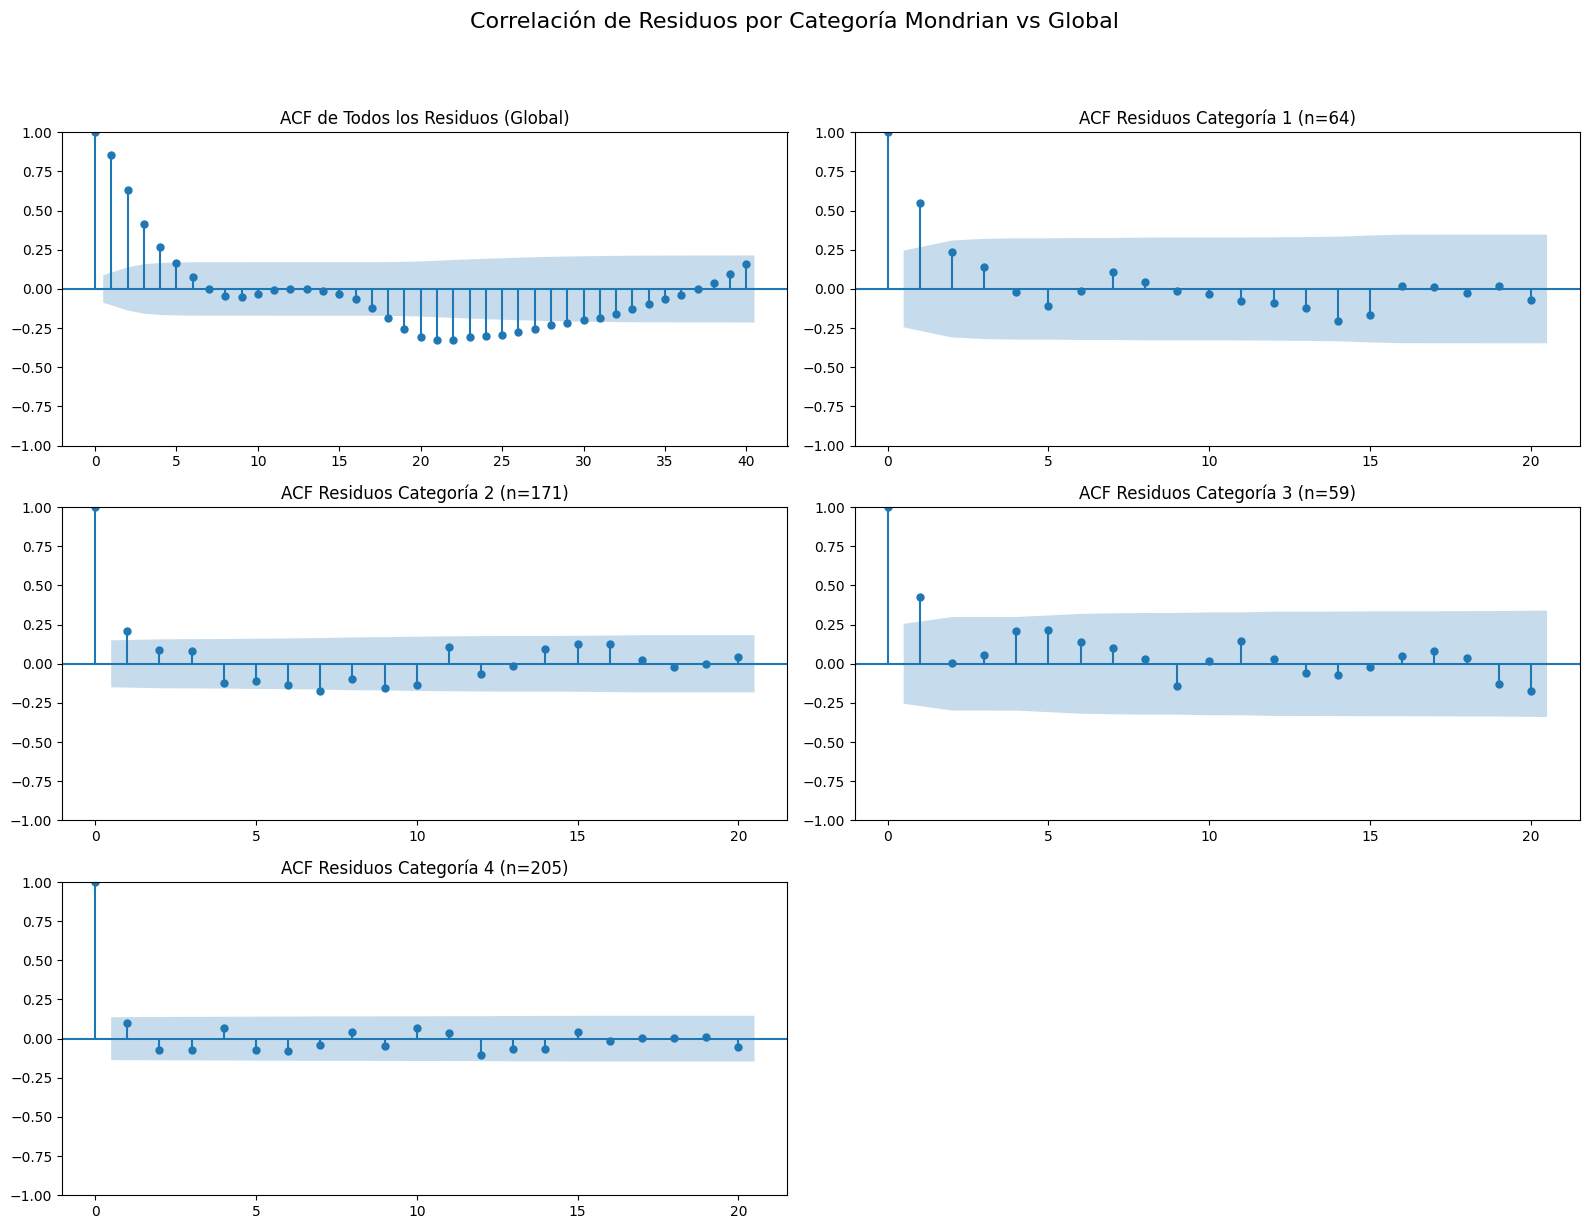


--- Análisis de correlación de grupos ---
Idealmente, las ACF de los residuos dentro de cada categoría Mondrian deberían mostrar una correlación significativamente menor (más cerca de ruido blanco) que la ACF de todos los residuos combinados. Los p-valores del test de Ljung-Box para cada categoría deberían ser mayores a 0.05 para indicar que los residuos dentro de esos grupos pueden considerarse IID.

4) Aplicando la metodología Mondrian para obtener la distribución predictiva...
El último residuo real es: -1.68
La categoría Mondrian para el siguiente punto (basada en el último real) es: 4

5) Generando la distribución predictiva final para el siguiente tiempo (CDF y PDF)...


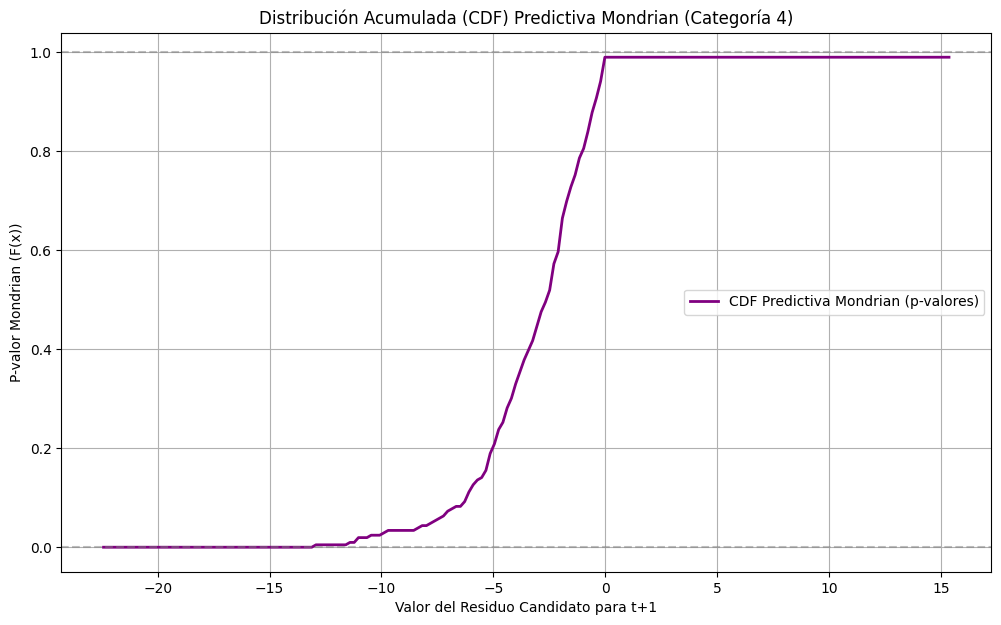

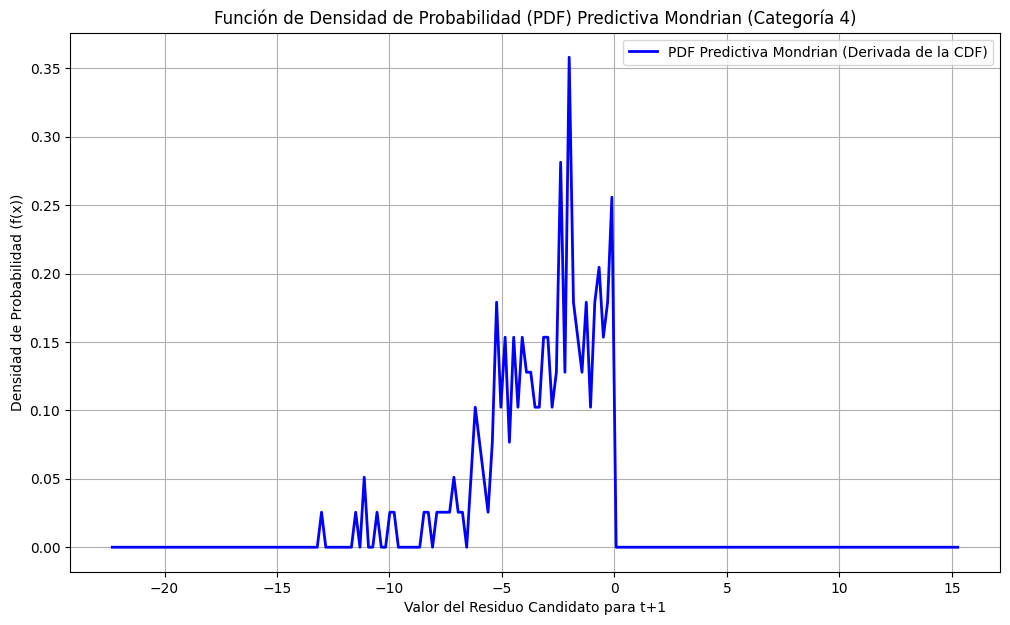


Intervalo de Predicción Mondrian (Nivel de Confianza 95%) para el siguiente residuo:
[-10.05, -0.08]


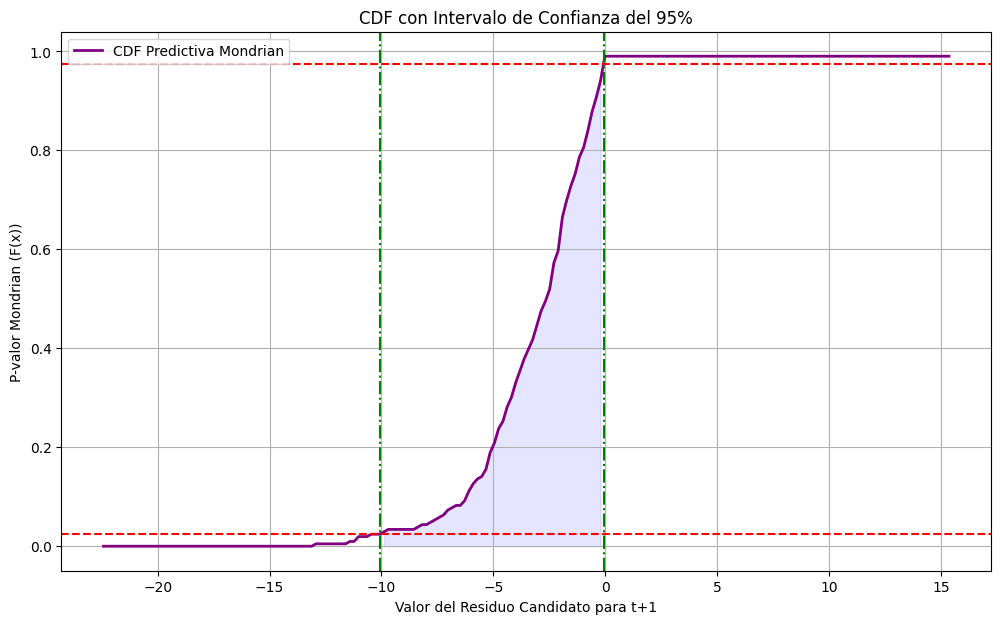

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox # Para el test de Ljung-Box
from scipy.stats import uniform
import scipy.signal
import warnings

# Suprimir advertencias para una salida más limpia
warnings.filterwarnings("ignore")

# 1) Simular una serie de tiempo ARIMA(1,0,2) con tendencia y estacionalidad

np.random.seed(42)
n_points = 500
freq = 24 # Frecuencia diaria (e.g., datos horarios para un día)
seasonal_period = freq # Período estacional (un ciclo diario)

print("1) Simulando una serie de tiempo ARIMA(1,0,2) con tendencia y estacionalidad...")

# 1.1) Generar tendencia
time = np.arange(n_points)
trend = 0.05 * time + np.sin(time / 50 * 2 * np.pi) * 10

# 1.2) Generar estacionalidad
seasonal_pattern = np.array([np.sin(2 * np.pi * i / freq) * 5 + np.cos(4 * np.pi * i / freq) * 2 for i in range(freq)])
seasonality = np.tile(seasonal_pattern, n_points // freq + 1)[:n_points]

# 1.3) Generar ruido ARIMA(1,0,2)
# Coeficiente AR(1): phi = 0.7
# Coeficientes MA(1) y MA(2): theta1 = 0.5, theta2 = 0.3
# Generamos ruido blanco y luego lo pasamos por los filtros ARMA.
white_noise = np.random.normal(loc=0, scale=3, size=n_points)

# Coeficientes para el filtro (usando scipy.signal.lfilter)
# Para ARMA(p,q): y[n] = b[0]*x[n] + ... + b[q]*x[n-q] - a[0]*y[n-1] - ... - a[p-1]*y[n-p]
# En statsmodels.tsa.arima.model.ARIMA, los coeficientes AR tienen signo positivo,
# así que para 'lfilter' se usan con signo negativo para el lado AR del filtro.
ar_coeffs_filter = np.r_[1, -0.7] # [1, -phi_1]
ma_coeffs_filter = np.r_[1, 0.5, 0.3] # [1, theta_1, theta_2]
arima_noise = scipy.signal.lfilter(ma_coeffs_filter, ar_coeffs_filter, white_noise)

# Combinar componentes para la serie de tiempo final
time_series = trend + seasonality + arima_noise

plt.figure(figsize=(14, 6))
plt.plot(time_series, label='Serie Temporal Simulada (con Tendencia, Estacionalidad y Ruido ARIMA)', color='blue')
plt.plot(trend, label='Tendencia', linestyle='--', color='green')
plt.plot(seasonality, label='Estacionalidad', linestyle=':', color='orange')
plt.legend()
plt.title('1) Serie Temporal Simulada')
plt.grid(True)
plt.show()

# 2) Quitar tendencia y estacionalidad

print("\n2) Quitando tendencia y estacionalidad usando descomposición STL...")

# CORRECCIÓN: `seasonal` debe ser un entero positivo impar >= 3
if seasonal_period % 2 == 0:
    stl_seasonal_param = seasonal_period + 1 
else:
    stl_seasonal_param = seasonal_period

if stl_seasonal_param < 3:
    stl_seasonal_param = 3 # Valor mínimo permitido

print(f"Usando seasonal_param = {stl_seasonal_param} para STL decomposition.")

stl = STL(time_series, seasonal=stl_seasonal_param, period=seasonal_period, robust=True)
res = stl.fit()

residuals = res.resid

plt.figure(figsize=(14, 6))
plt.plot(time_series, label='Serie Temporal Original', color='blue')
plt.plot(res.trend, label='Componente de Tendencia STL', linestyle='--', color='green')
plt.plot(res.seasonal, label='Componente de Estacionalidad STL', linestyle=':', color='orange')
plt.plot(residuals, label='Residuos (Ruido)', color='red', alpha=0.7)
plt.legend()
plt.title('Descomposición STL y Residuos')
plt.grid(True)
plt.show()

# Eliminar los valores NaN que puedan aparecer al inicio/final de los residuos por la descomposición STL
residuals = residuals[~np.isnan(residuals)]

if len(residuals) < 2: # Necesitamos al menos 2 residuos para definir categorías basadas en el residuo anterior
    raise ValueError("No hay suficientes residuos después de la descomposición para el análisis Mondrian.")

# 3) Definir los k grupos por medio de un clasificador (Taxonomía Mondrian)

print("\n3) Definiendo k grupos Mondrian usando una taxonomía basada en el residuo anterior...")

# Vamos a usar una taxonomía Mondrian simple basada en:
# 1. El signo del residuo ANTERIOR
# 2. Si su magnitud es "alta" o "baja" respecto a un umbral (e.g., la desviación estándar)
# Esto crea 4 categorías:
# Categoría 1: residuo_anterior > 0 y abs(residuo_anterior) > threshold
# Categoría 2: residuo_anterior > 0 y abs(residuo_anterior) <= threshold
# Categoría 3: residuo_anterior <= 0 y abs(residuo_anterior) > threshold
# Categoría 4: residuo_anterior <= 0 y abs(residuo_anterior) <= threshold

# Calcular el umbral de magnitud (e.g., la desviación estándar de los residuos)
magnitude_threshold = np.std(residuals)

# Asignar categorías a cada residuo basándose en el residuo ANTERIOR
# El residuo `residuals[i]` se categoriza usando `residuals[i-1]`
categories = np.zeros(len(residuals), dtype=int)

# El primer residuo (en el índice 0) no tiene un residuo anterior para la clasificación
# En la práctica Mondrian, los puntos que no pueden ser categorizados de forma consistente
# según la taxonomía (por falta de datos previos) se manejan por separado o se excluyen.
# Para el cálculo de p-valores, solo consideraremos `residuals` desde el índice 1,
# donde `categories[i]` se basará en `residuals[i-1]`.
categories[0] = -1 # Categoría especial para el primer punto, que será ignorado en el Mondrian real

for i in range(1, len(residuals)):
    prev_resid = residuals[i-1]
    
    is_positive = prev_resid > 0
    is_high_magnitude = np.abs(prev_resid) > magnitude_threshold

    if is_positive and is_high_magnitude:
        categories[i] = 1
    elif is_positive and not is_high_magnitude:
        categories[i] = 2
    elif not is_positive and is_high_magnitude:
        categories[i] = 3
    else: # not is_positive and not is_high_magnitude
        categories[i] = 4

# Filtrar residuos y categorías para el análisis Mondrian (ignorar categories[0] == -1)
mondrian_residuals = residuals[categories != -1]
mondrian_categories = categories[categories != -1]

print(f"Taxonomía Mondrian (basada en el residuo anterior):")
print(f"Primeros 10 residuos (sin el primero): {mondrian_residuals[:10].round(2)}")
print(f"Categorías asignadas (sin el primero): {mondrian_categories[:10]}")
unique_cats = np.unique(mondrian_categories)
for cat_id in unique_cats:
    print(f"  Categoría {cat_id}: {np.sum(mondrian_categories == cat_id)} residuos")


# 3.5) Revisar qué tan correlacionados quedan los grupos y Test de Ljung-Box

print("\n3.5) Revisando la correlación de los residuos dentro de cada grupo y aplicando el test de Ljung-Box...")

plt.figure(figsize=(16, 12))

# ACF de todos los residuos (para comparación)
plt.subplot(3, 2, 1)
plot_acf(residuals, lags=40, ax=plt.gca(), title='ACF de Todos los Residuos (Global)')
plt.tight_layout()

# Test de Ljung-Box para todos los residuos
# Usaremos un número de lags significativo, por ejemplo, el 10% del número de puntos o hasta 30
lags_to_test = min(int(len(residuals) * 0.1), 30)
if lags_to_test < 1: lags_to_test = 1 # Asegurarse de tener al menos 1 lag para el test
ljungbox_global_test = acorr_ljungbox(residuals, lags=[lags_to_test], return_df=True)
print(f"\n--- Test de Ljung-Box para TODOS los Residuos (Global, lags={lags_to_test}) ---")
print(ljungbox_global_test)
if ljungbox_global_test['lb_pvalue'].iloc[0] < 0.05:
    print("El test de Ljung-Box RECHAZA la hipótesis nula de no autocorrelación. Los residuos globales NO son IID.")
else:
    print("El test de Ljung-Box NO RECHAZA la hipótesis nula de no autocorrelación. Los residuos globales podrían ser IID.")


# ACFs y Test de Ljung-Box por categoría Mondrian
print("\n--- Test de Ljung-Box por Categoría Mondrian ---")
for i, cat_id in enumerate(unique_cats):
    cat_residuals = mondrian_residuals[mondrian_categories == cat_id]
    
    if len(cat_residuals) > 10: # Necesitamos suficientes puntos para calcular la ACF y el test
        ax = plt.subplot(3, 2, i + 2) # Ajustar para 4 categorías + global
        plot_acf(cat_residuals, lags=min(20, len(cat_residuals)//2 - 1), ax=ax, title=f'ACF Residuos Categoría {cat_id} (n={len(cat_residuals)})')
        
        # Test de Ljung-Box para los residuos de la categoría
        lags_cat_test = min(int(len(cat_residuals) * 0.1), 10) # Menos lags para grupos más pequeños
        if lags_cat_test >= 1:
            ljungbox_cat_test = acorr_ljungbox(cat_residuals, lags=[lags_cat_test], return_df=True)
            print(f"Categoría {cat_id} (n={len(cat_residuals)}, lags={lags_cat_test}):")
            print(ljungbox_cat_test)
            if ljungbox_cat_test['lb_pvalue'].iloc[0] < 0.05:
                print(f"  El test de Ljung-Box RECHAZA la hipótesis nula de no autocorrelación en la Categoría {cat_id}. NO son IID.")
            else:
                print(f"  El test de Ljung-Box NO RECHAZA la hipótesis nula de no autocorrelación en la Categoría {cat_id}. Podrían ser IID.")
        else:
            print(f"  No hay suficientes lags para el test de Ljung-Box en la Categoría {cat_id}.")
    else:
        print(f"Advertencia: No hay suficientes residuos en la categoría {cat_id} para plotear la ACF o realizar el test de Ljung-Box.")

plt.suptitle('Correlación de Residuos por Categoría Mondrian vs Global', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar layout para el título superior
plt.show()

print("\n--- Análisis de correlación de grupos ---")
print("Idealmente, las ACF de los residuos dentro de cada categoría Mondrian deberían mostrar una correlación significativamente menor (más cerca de ruido blanco) que la ACF de todos los residuos combinados. Los p-valores del test de Ljung-Box para cada categoría deberían ser mayores a 0.05 para indicar que los residuos dentro de esos grupos pueden considerarse IID.")


# 4) Aplicar la metodología Mondrian para obtener la distribución predictiva

print("\n4) Aplicando la metodología Mondrian para obtener la distribución predictiva...")

# Queremos predecir el residuo en el tiempo n_points (el siguiente)
# La categoría de este siguiente punto se basará en el ÚLTIMO residuo conocido
last_actual_resid = mondrian_residuals[-1] # Último residuo real disponible
# La categoría del último residuo real (mondrian_categories[-1]) se basó en residuals[-2]
# Para el siguiente punto (t+1), su categoría se determina usando last_actual_resid (residuals[-1])
is_positive_next_point = last_actual_resid > 0
is_high_magnitude_next_point = np.abs(last_actual_resid) > magnitude_threshold

if is_positive_next_point and is_high_magnitude_next_point:
    next_point_category = 1
elif is_positive_next_point and not is_high_magnitude_next_point:
    next_point_category = 2
elif not is_positive_next_point and is_high_magnitude_next_point:
    next_point_category = 3
else: # not is_positive_next_point and not is_high_magnitude_next_point
    next_point_category = 4

print(f"El último residuo real es: {last_actual_resid:.2f}")
print(f"La categoría Mondrian para el siguiente punto (basada en el último real) es: {next_point_category}")

# Seleccionar los residuos históricos que pertenecen a esta categoría para la predicción
historical_residuals_in_next_category = mondrian_residuals[mondrian_categories == next_point_category]

if len(historical_residuals_in_next_category) < 2: # Necesitamos al menos 2 puntos (1 para comparar, 1 para la N_effective)
    print(f"Advertencia: No hay suficientes residuos históricos ({len(historical_residuals_in_next_category)}) en la categoría {next_point_category} para formar una distribución Mondrian significativa.")
    print("La distribución predictiva será muy incierta o vacua. Se usará un rango por defecto y p-valores planos.")
    candidate_residuals = np.linspace(-10, 10, 100) # Rango por defecto
    p_values_for_plot = np.full_like(candidate_residuals, 0.5) # Valores planos por defecto
else:
    # Definir la medida de no conformidad: simplemente el valor absoluto del residuo
    def nonconformity_measure(resid):
        return np.abs(resid)

    # Generar un rango de valores candidatos para el siguiente residuo
    # Estos valores representan el eje 'y' de la distribución predictiva
    min_res_cat = np.min(historical_residuals_in_next_category)
    max_res_cat = np.max(historical_residuals_in_next_category)
    
    # Expandir el rango un poco para ver la "cola"
    # Asegurarse de que min_res_cat y max_res_cat no sean el mismo valor para evitar división por cero o rango cero
    if min_res_cat == max_res_cat:
        range_extension = magnitude_threshold * 2 
    else:
        range_extension = (max_res_cat - min_res_cat) * 0.5
    
    candidate_residuals = np.linspace(min_res_cat - range_extension, max_res_cat + range_extension, 200)

    # Calcular los p-valores para cada residuo candidato
    p_values_for_plot = []
    
    # Calcular scores de no conformidad para los residuos históricos en la categoría
    historical_scores = np.array([nonconformity_measure(r) for r in historical_residuals_in_next_category])
    
    # Semilla para los valores tau para reproducibilidad si se ejecuta varias veces
    np.random.seed(43) 
    
    for cand_resid in candidate_residuals:
        cand_score = nonconformity_measure(cand_resid)
        
        # Calcular los componentes del p-valor suavizado (según la fórmula del libro 2.2.6 adaptada a Mondrian)
        # pn = (|{i: kappa_i = kappa_n & alpha_i > alpha_n}| + tau * |{i: kappa_i = kappa_n & alpha_i = alpha_n}|) / |{i: kappa_i = kappa_n}|
        # Aquí, alpha_n es cand_score, y 'i's son los historical_scores.
        
        count_greater_than_cand = np.sum(historical_scores > cand_score)
        count_equal_to_cand = np.sum(historical_scores == cand_score)
        
        n_effective_in_category = len(historical_scores) + 1 # Incluye el candidato virtual para el cálculo del p-valor
        
        # Un nuevo valor tau para cada cálculo de p-valor del candidato
        current_tau = uniform.rvs(size=1)[0]
        
        smoothed_p_value = (count_greater_than_cand + current_tau * count_equal_to_cand) / n_effective_in_category
        p_values_for_plot.append(smoothed_p_value)

    # Ordenar los p-valores junto con los residuos candidatos para formar la CDF (monótona)
    sorted_indices = np.argsort(candidate_residuals)
    sorted_candidate_residuals = candidate_residuals[sorted_indices]
    sorted_p_values_for_plot = np.array(p_values_for_plot)[sorted_indices]
    
    # Asegurar monotonicidad estricta para la interpolación inversa (aunque los p-valores suavizados deberían ser monótonos por diseño)
    # Algunos casos límite pueden romper la monotonicidad. Podemos forzarla.
    for i in range(1, len(sorted_p_values_for_plot)):
        if sorted_p_values_for_plot[i] < sorted_p_values_for_plot[i-1]:
            sorted_p_values_for_plot[i] = sorted_p_values_for_plot[i-1]


# 5) Dame una distribución final para el siguiente tiempo (CDF y PDF)

print("\n5) Generando la distribución predictiva final para el siguiente tiempo (CDF y PDF)...")

# --- CDF ---
plt.figure(figsize=(12, 7))
plt.plot(sorted_candidate_residuals, sorted_p_values_for_plot, label='CDF Predictiva Mondrian (p-valores)', color='purple', linewidth=2)
plt.xlabel('Valor del Residuo Candidato para t+1')
plt.ylabel('P-valor Mondrian (F(x))')
plt.title(f'Distribución Acumulada (CDF) Predictiva Mondrian (Categoría {next_point_category})')
plt.grid(True)
plt.legend()
plt.axhline(y=0.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
plt.show()

# --- PDF ---
# Derivar la PDF de la CDF
# La PDF se aproxima por la diferencia en los p-valores dividida por la diferencia en los residuos candidatos.
# Tomamos el punto medio de los intervalos para el eje x de la PDF.

pdf_residuals = (sorted_candidate_residuals[:-1] + sorted_candidate_residuals[1:]) / 2
pdf_values = np.diff(sorted_p_values_for_plot) / np.diff(sorted_candidate_residuals)

# Normalizar la PDF para que el área bajo la curva sume 1 (aproximadamente)
# La suma de pdf_values * delta_x debe ser 1.
# sum(pdf_values * np.diff(sorted_candidate_residuals)) = sum(np.diff(sorted_p_values_for_plot)) = sorted_p_values_for_plot[-1] - sorted_p_values_for_plot[0]
# Si la CDF va de 0 a 1, esto ya es 1. Pero si no, normalizamos para que el "área" sume 1.
# En este caso, como los p-valores van de 0 a 1, la suma de las diferencias es 1.
# Simplemente graficamos las "alturas" de la densidad.

plt.figure(figsize=(12, 7))
plt.plot(pdf_residuals, pdf_values, label='PDF Predictiva Mondrian (Derivada de la CDF)', color='blue', linewidth=2)
plt.xlabel('Valor del Residuo Candidato para t+1')
plt.ylabel('Densidad de Probabilidad (f(x))')
plt.title(f'Función de Densidad de Probabilidad (PDF) Predictiva Mondrian (Categoría {next_point_category})')
plt.grid(True)
plt.legend()
plt.show()

# Cálculo y visualización de un intervalo de predicción (e.g., 95%)

confidence_level = 0.95
lower_epsilon_quantile = (1 - confidence_level) / 2 # e.g., 0.025
upper_epsilon_quantile = 1 - lower_epsilon_quantile # e.g., 0.975

# Interpolación lineal para encontrar los valores de residuos correspondientes a estos p-valores
# np.interp asume que el primer argumento (p_values) está ordenado ascendentemente.
# Si la distribución predictiva es monótona, esto funciona como una función inversa.
pred_lower_bound = np.interp(lower_epsilon_quantile, sorted_p_values_for_plot, sorted_candidate_residuals)
pred_upper_bound = np.interp(upper_epsilon_quantile, sorted_p_values_for_plot, sorted_candidate_residuals)

print(f"\nIntervalo de Predicción Mondrian (Nivel de Confianza {confidence_level*100:.0f}%) para el siguiente residuo:")
print(f"[{pred_lower_bound:.2f}, {pred_upper_bound:.2f}]")

plt.figure(figsize=(12, 7))
plt.plot(sorted_candidate_residuals, sorted_p_values_for_plot, label='CDF Predictiva Mondrian', color='purple', linewidth=2)
plt.xlabel('Valor del Residuo Candidato para t+1')
plt.ylabel('P-valor Mondrian (F(x))')
plt.title(f'CDF con Intervalo de Confianza del {confidence_level*100:.0f}%')
plt.grid(True)
plt.legend()
plt.axhline(y=lower_epsilon_quantile, color='red', linestyle='--', label=f'Cuantil Inferior de P-valor ({lower_epsilon_quantile:.3f})')
plt.axhline(y=upper_epsilon_quantile, color='red', linestyle='--', label=f'Cuantil Superior de P-valor ({upper_epsilon_quantile:.3f})')
plt.axvline(x=pred_lower_bound, color='green', linestyle='-.', label=f'Límite Inferior del Intervalo ({pred_lower_bound:.2f})')
plt.axvline(x=pred_upper_bound, color='green', linestyle='-.', label=f'Límite Superior del Intervalo ({pred_upper_bound:.2f})')
plt.fill_between(sorted_candidate_residuals, 0, sorted_p_values_for_plot, where=(sorted_p_values_for_plot >= lower_epsilon_quantile) & (sorted_p_values_for_plot <= upper_epsilon_quantile), color='blue', alpha=0.1, label='Región de Confianza')
plt.show()

# Datos reales - 1 IPG2211A2N

Iniciando análisis de Predicción Conformal Mondrian Riguroso con datos reales.

1) Cargando datos desde ../data/Electric_Production.csv...
Datos cargados. 397 puntos desde 1985-01-01 00:00:00 hasta 2018-01-01 00:00:00.
Primeros 5 valores de la serie:
DATE
1985-01-01    72.5052
1985-02-01    70.6720
1985-03-01    62.4502
1985-04-01    57.4714
1985-05-01    55.3151
Name: IPG2211A2N, dtype: float64

Serie dividida: 387 puntos para entrenamiento inicial, 10 para prueba.

Descomposición STL inicial exitosa en la serie de entrenamiento.

Visualizando la descomposición STL de la serie de entrenamiento inicial:


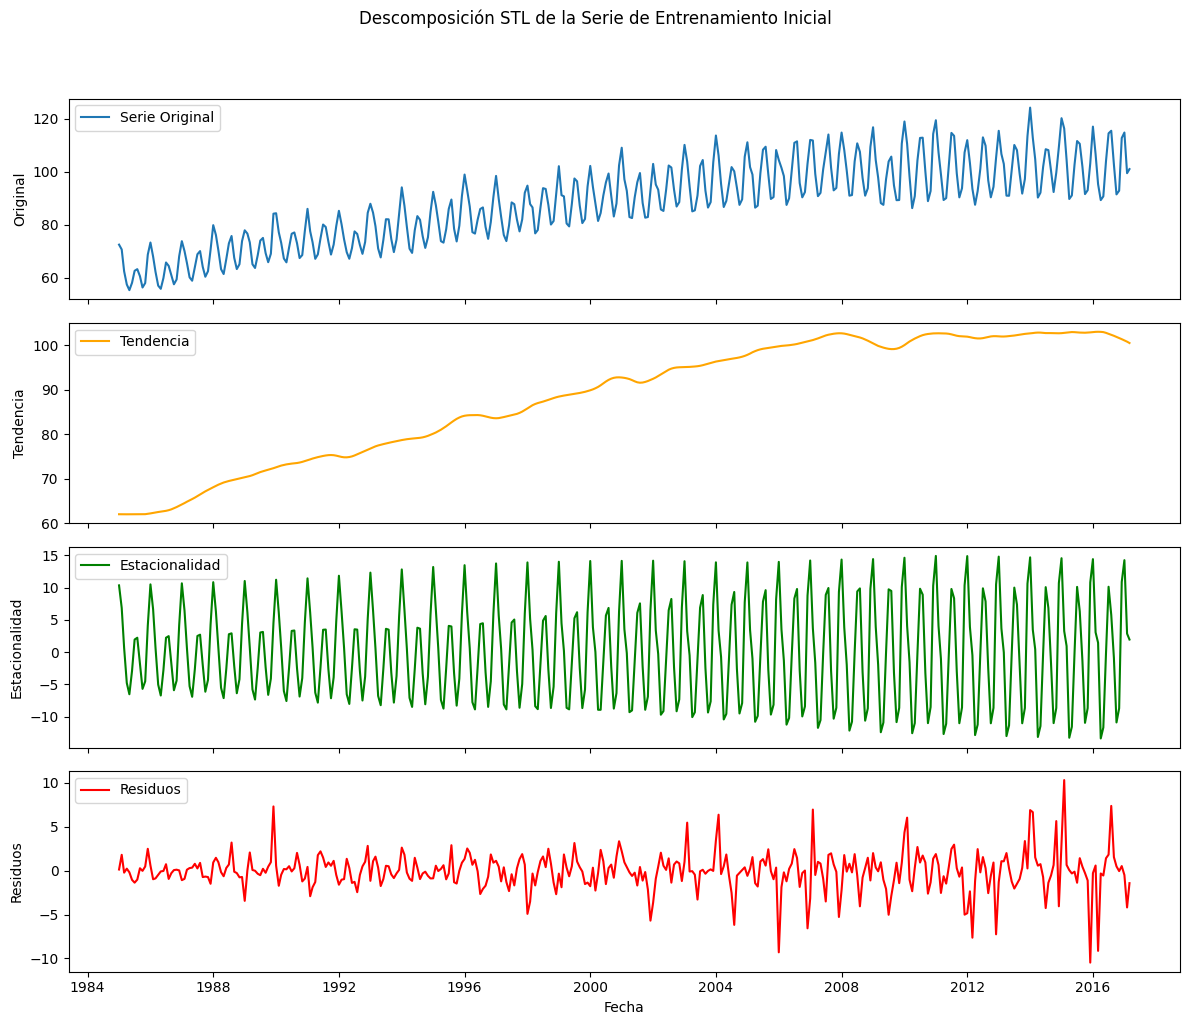


Iniciando proceso de predicción en ventana deslizante...

--- RESUMEN FINAL DE PREDICCIONES EN EL CONJUNTO DE PRUEBA ---
CRPS Promedio en el conjunto de prueba (10 puntos): 3.2477


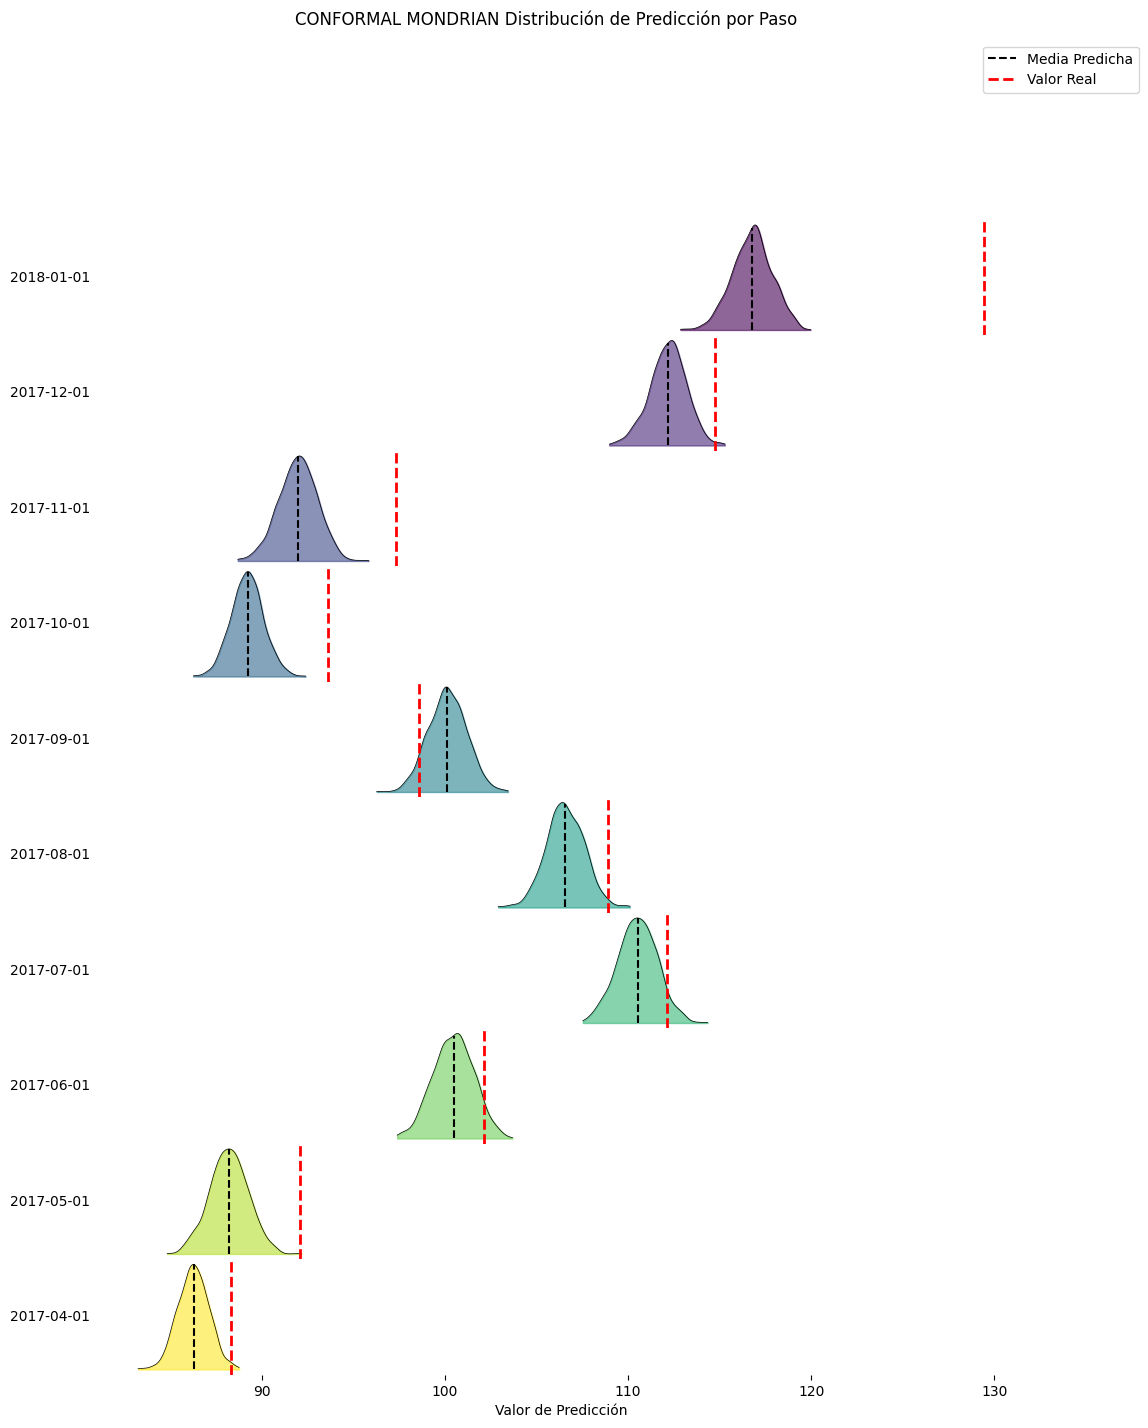


Tabla de Resumen de Predicciones:


,Fecha Predicción,Valor Real,Media Predictiva,CRPS,Cat. Mondrian,Residuo Medio Est.,Residuo Std Est.,Tendencia STL,Estacionalidad STL
0,2017-04-01,88.3530,86.297679,1.559024,4,-0.85,0.89,100.51,-13.36
1,2017-05-01,92.0805,88.247336,3.235653,2,-0.95,1.06,100.83,-11.63
2,2017-06-01,102.1532,100.501643,1.112589,2,-0.92,1.05,101.47,-0.05
3,2017-07-01,112.1538,110.591202,1.031648,2,-0.94,1.06,101.53,10.00
4,2017-08-01,108.9312,106.610717,1.733298,2,-0.95,1.06,101.58,5.98
5,2017-09-01,98.6154,100.110260,0.981444,2,-0.92,1.03,101.97,-0.94
6,2017-10-01,93.6137,89.183997,3.934135,4,-0.86,0.88,101.13,-11.09
7,2017-11-01,97.3359,91.899068,4.850109,2,-0.93,1.04,101.97,-9.14
8,2017-12-01,114.7212,112.136736,2.008806,2,-0.97,1.03,103.23,9.88
9,2018-01-01,129.4048,116.772823,12.030577,2,-0.96,1.07,103.96,13.77


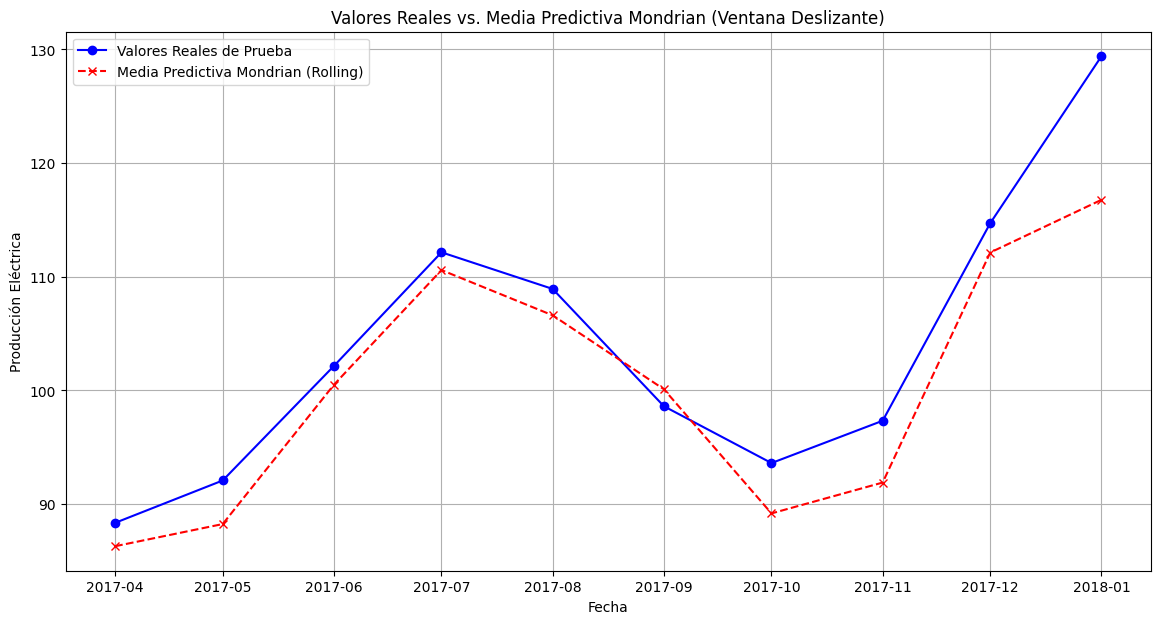

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.stats import uniform, norm, gaussian_kde
import warnings
from typing import Optional, Any # Importaciones necesarias para la función de visualización

# Suprimir advertencias para una salida más limpia
warnings.filterwarnings("ignore")

# --- Configuración ---
RANDOM_SEED = 10 # Semilla para reproducibilidad
DATA_PATH = "../data/Electric_Production.csv"
TARGET_COLUMN = 'IPG2211A2N'
SEASONAL_PERIOD = 12 # Para datos mensuales, el período estacional es 12. Este es el *periodo* de los datos.
N_LAGS_ACF = 40 
N_LAGS_LJUNG_BOX = 10 
N_TEST_POINTS = 10 # Número de últimos puntos para usar como test
N_CANDIDATE_RESIDUALS_FOR_DIST = 200 # Número de puntos para la discretización de la distribución predictiva
N_SAMPLES_FOR_VISUALIZATION = 1000 # Nuevo: número de muestras a generar para la visualización KDE

# Calcular la longitud de la ventana de suavizado estacional para STL.
# Debe ser un entero impar >= 3.
# Si SEASONAL_PERIOD es par, se le suma 1 para que sea impar.
stl_seasonal_window_length = SEASONAL_PERIOD + 1 if SEASONAL_PERIOD % 2 == 0 else SEASONAL_PERIOD
if stl_seasonal_window_length < 3: # Asegurarse de que sea al menos 3
    stl_seasonal_window_length = 3

# Establecer la semilla global para NumPy
np.random.seed(RANDOM_SEED)

print("Iniciando análisis de Predicción Conformal Mondrian Riguroso con datos reales.")

# 1) Carga de Datos Reales
print(f"\n1) Cargando datos desde {DATA_PATH}...")
try:
    df = pd.read_csv(DATA_PATH, index_col='DATE', parse_dates=['DATE'])
    series_full = df[TARGET_COLUMN]
    print(f"Datos cargados. {len(series_full)} puntos desde {series_full.index.min()} hasta {series_full.index.max()}.")
    print(f"Primeros 5 valores de la serie:\n{series_full.head()}")
except FileNotFoundError:
    print(f"ERROR: El archivo {DATA_PATH} no se encontró. Asegúrate de que la ruta sea correcta.")
    exit()
except Exception as e:
    print(f"ERROR al cargar o procesar el archivo: {e}")
    exit()

# --- División de datos en entrenamiento y prueba ---
if len(series_full) <= N_TEST_POINTS:
    raise ValueError(f"La serie de tiempo es demasiado corta para {N_TEST_POINTS} puntos de prueba.")
    
series_train_initial = series_full.iloc[:-N_TEST_POINTS]
series_test = series_full.iloc[-N_TEST_POINTS:]

print(f"\nSerie dividida: {len(series_train_initial)} puntos para entrenamiento inicial, {len(series_test)} para prueba.")

# Descomposición STL inicial para obtener los parámetros de la primera STL y para el fallback
res_train = None
residuals_train = pd.Series([], dtype=float)
try:
    # Usar stl_seasonal_window_length para el parámetro 'seasonal' de STL
    stl_initial = STL(series_train_initial, period=SEASONAL_PERIOD, seasonal=stl_seasonal_window_length, robust=True)
    res_train = stl_initial.fit()
    residuals_train = res_train.resid[~np.isnan(res_train.resid)]
    print("\nDescomposición STL inicial exitosa en la serie de entrenamiento.")

    # --- Visualización de la Descomposición STL ---
    print("\nVisualizando la descomposición STL de la serie de entrenamiento inicial:")
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    ax1.plot(series_train_initial, label='Serie Original')
    ax1.set_ylabel('Original')
    ax1.legend()

    ax2.plot(res_train.trend, label='Tendencia', color='orange')
    ax2.set_ylabel('Tendencia')
    ax2.legend()

    ax3.plot(res_train.seasonal, label='Estacionalidad', color='green')
    ax3.set_ylabel('Estacionalidad')
    ax3.legend()

    ax4.plot(res_train.resid, label='Residuos', color='red')
    ax4.set_ylabel('Residuos')
    ax4.legend()

    plt.xlabel('Fecha')
    plt.suptitle('Descomposición STL de la Serie de Entrenamiento Inicial', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar layout para el título
    plt.show()

except Exception as e:
    print(f"Advertencia: Error en la descomposición STL inicial o en su visualización: {e}. Puede afectar el fallback.")


# --- Funciones de ayuda reutilizables ---

def nonconformity_measure(resid):
    return np.abs(resid)

def get_mondrian_category(prev_resid, threshold):
    is_positive = prev_resid > 0
    is_high_magnitude = np.abs(prev_resid) > threshold

    if is_positive and is_high_magnitude:
        return 1
    elif is_positive and not is_high_magnitude:
        return 2
    elif not is_positive and is_high_magnitude:
        return 3
    else:
        return 4

def calculate_mondrian_cdf_from_residuals(historical_residuals_in_category, magnitude_threshold):
    if len(historical_residuals_in_category) < 2:
        candidate_residuals_range = np.linspace(-15, 15, N_CANDIDATE_RESIDUALS_FOR_DIST)
        return candidate_residuals_range, np.full_like(candidate_residuals_range, 0.5), np.nan, np.nan

    min_hist_res = np.min(historical_residuals_in_category)
    max_hist_res = np.max(historical_residuals_in_category)
    
    if min_hist_res == max_hist_res:
        range_extension = magnitude_threshold * 2 
    else:
        range_extension = (max_hist_res - min_hist_res) * 0.5
    
    candidate_residuals_range = np.linspace(min_hist_res - range_extension, max_hist_res + range_extension, N_CANDIDATE_RESIDUALS_FOR_DIST)

    p_values = []
    historical_scores = np.array([nonconformity_measure(r) for r in historical_residuals_in_category])
    
    for cand_resid in candidate_residuals_range:
        cand_score = nonconformity_measure(cand_resid)
        
        count_greater_than_cand = np.sum(historical_scores > cand_score)
        count_equal_to_cand = np.sum(historical_scores == cand_score)
        
        n_effective_in_category = len(historical_scores) + 1
        current_tau = uniform.rvs(size=1)[0] # Usará la semilla global
        
        smoothed_p_value = (count_greater_than_cand + current_tau * count_equal_to_cand) / n_effective_in_category
        p_values.append(smoothed_p_value)

    sorted_indices = np.argsort(candidate_residuals_range)
    sorted_candidate_residuals = candidate_residuals_range[sorted_indices]
    sorted_p_values = np.array(p_values)[sorted_indices]
    
    for k in range(1, len(sorted_p_values)):
        if sorted_p_values[k] < sorted_p_values[k-1]:
            sorted_p_values[k] = sorted_p_values[k-1]
            
    q25 = np.interp(0.25, sorted_p_values, sorted_candidate_residuals)
    q50 = np.interp(0.50, sorted_p_values, sorted_candidate_residuals)
    q75 = np.interp(0.75, sorted_p_values, sorted_candidate_residuals)

    estimated_mean = q50
    estimated_std = (q75 - q25) / (2 * norm.ppf(0.75)) if (q75 - q25) > 0 else magnitude_threshold

    return sorted_candidate_residuals, sorted_p_values, estimated_mean, estimated_std

def calculate_crps_gaussian(observed_value, mean, std):
    if np.isnan(mean) or np.isnan(std) or std <= 0:
        return np.inf
    
    z = (observed_value - mean) / std
    crps = std * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))
    return crps

# --- Función de visualización adaptada ---
def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame,
                                 model_type: str,
                                 test_data: pd.Series,
                                 bw_method: Optional[Any] = None,
                                 **fig_kw) -> plt.Figure:
    
    # El índice se invierte para que el paso de tiempo más reciente esté en la parte inferior del gráfico apilado
    index_to_plot = bootstrapping_predictions.index.astype(str).to_list()[::-1] 
    palette = plt.cm.viridis(np.linspace(0, 1, len(index_to_plot)))
    
    fig_kw.pop('test_data', None) # Asegurarse de que test_data no se pase a subplots
    
    # Calcular el tamaño de la figura automáticamente. Ajustar el factor 2 para espaciado vertical
    fig, axs = plt.subplots(len(index_to_plot), 1, sharex=True, figsize=(fig_kw.get('figsize', (12, 1.5 * len(index_to_plot)))))
    
    if not isinstance(axs, np.ndarray): # Para el caso de un solo subplot
        axs = np.array([axs])

    legend_handles = []
    legend_labels = []

    for i, step in enumerate(index_to_plot):
        # Calcular KDE para las muestras del paso actual
        samples = bootstrapping_predictions.loc[step, :].dropna()
        
        if len(samples) > 1 and samples.std() > 1e-6:
            kde_func = gaussian_kde(samples, bw_method=bw_method)
            # Crear un rango más denso para plotear el KDE
            x_values = np.linspace(samples.min() - 0.1 * samples.std(), samples.max() + 0.1 * samples.std(), 500)
            y_values = kde_func(x_values)
            axs[i].plot(x_values, y_values, lw=0.5, color='black') # Plotear la línea KDE
            axs[i].fill_between(x_values, y_values, color=palette[i], alpha=0.6)
            
            # Línea de la media
            prediction_mean = samples.mean()
            idx = np.abs(x_values - prediction_mean).argmin()
            mean_line = axs[i].vlines(x_values[idx], ymin=0, ymax=y_values[idx], linestyle="dashed", color='black', label='Media Predicha')
        else:
            # Fallback para muy pocas muestras o muestras constantes: plotear una línea en la media
            prediction_mean = samples.mean() if len(samples) > 0 else 0
            mean_line = axs[i].axvline(x=prediction_mean, color='black', linestyle='dashed', linewidth=1, label='Media Predicha (Degenerada)')
            if len(samples) <= 1:
                axs[i].text(prediction_mean, 0.5, 'Distribución Degenerada', transform=axs[i].get_xaxis_transform(), 
                            color='grey', va='center', ha='center', fontsize=8)
        
        # Plotear el valor real de prueba en rojo
        real_value = test_data.loc[step]
        actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2, label='Valor Real')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal', ha='right', va='center') # Ajustar posición de la etiqueta
        if i == len(index_to_plot) - 1: # Solo establecer xlabel para el subplot inferior
            axs[i].set_xlabel('Valor de Predicción')
        else:
            axs[i].set_xlabel('') # Eliminar xlabel para los demás
        
        if i == 0: # Recolectar handles y labels de la leyenda solo una vez (para el primer subplot dibujado, que es el más reciente)
            # Asegurarse de no duplicar si la leyenda ya existe por el fallback
            current_handles, current_labels = axs[i].get_legend_handles_labels()
            for handle, label in zip(current_handles, current_labels):
                if label not in legend_labels:
                    legend_handles.append(handle)
                    legend_labels.append(label)

    fig.subplots_adjust(hspace=-0)
    model_title = f"{model_type.upper()} Distribución de Predicción por Paso"
    fig.suptitle(model_title, y=1.02) # Ajustar posición del título
    
    # Añadir una única leyenda para toda la figura
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)

    return fig


# --- Proceso principal de ventana deslizante ---
crps_results = []
predicted_values_overview = []
actual_values_overview = []
prediction_times = []
all_prediction_samples = [] # Lista para almacenar las series de muestras de cada paso de predicción

# Nuevas listas para el resumen
mondrian_categories_used = []
estimated_resid_means = []
estimated_resid_stds = []
trend_comps = []
seasonal_comps = []

current_historical_series = series_train_initial.copy()

print("\nIniciando proceso de predicción en ventana deslizante...")
for i in range(N_TEST_POINTS):
    test_point_index = series_test.index[i]
    actual_test_value = series_test.iloc[i]
    prediction_times.append(test_point_index)
    actual_values_overview.append(actual_test_value)

    current_trend_comp = np.nan
    current_seasonal_comp = np.nan
    
    if len(current_historical_series) < SEASONAL_PERIOD * 2:
        print("  Advertencia: Serie histórica demasiado corta para STL robusta. Usando descomposición previa o promedios.")
        if res_train is not None and not residuals_train.empty:
            residuals_current = residuals_train.copy()
            current_trend_comp = res_train.trend.iloc[-1]
            current_seasonal_comp = res_train.seasonal.iloc[-SEASONAL_PERIOD]
        else:
            print("  Error: No hay descomposición STL inicial disponible para fallback.")
            residuals_current = current_historical_series - current_historical_series.mean() if len(current_historical_series) > 0 else pd.Series([], dtype=float)
            current_trend_comp = current_historical_series.mean() if len(current_historical_series) > 0 else 0
            current_seasonal_comp = 0
    else:
        stl_current = STL(current_historical_series, period=SEASONAL_PERIOD, seasonal=stl_seasonal_window_length, robust=True)
        res_current = stl_current.fit()
        residuals_current = res_current.resid[~np.isnan(res_current.resid)]
        current_trend_comp = res_current.trend.iloc[-1]
        current_seasonal_comp = res_current.seasonal.iloc[-SEASONAL_PERIOD]

    if len(residuals_current) < 2 or np.isnan(current_trend_comp) or np.isnan(current_seasonal_comp):
        print("  Error: No hay suficientes residuos o componentes STL válidos en la ventana actual. Saltando predicción.")
        crps_results.append(np.inf)
        predicted_values_overview.append(np.nan)
        # Añadir NaNs para la tabla resumen y las muestras
        mondrian_categories_used.append(np.nan)
        estimated_resid_means.append(np.nan)
        estimated_resid_stds.append(np.nan)
        trend_comps.append(np.nan)
        seasonal_comps.append(np.nan)
        all_prediction_samples.append(pd.Series([np.nan] * N_SAMPLES_FOR_VISUALIZATION, name=test_point_index)) 
        current_historical_series = pd.concat([current_historical_series, pd.Series([actual_test_value], index=[test_point_index])])
        continue

    magnitude_threshold_current = np.std(residuals_current)
    if magnitude_threshold_current == 0:
        magnitude_threshold_current = 0.01
        
    categories_current = np.zeros(len(residuals_current), dtype=int)
    if len(residuals_current) > 0:
        categories_current[0] = -1
        for j in range(1, len(residuals_current)):
            prev_resid = residuals_current.iloc[j-1]
            categories_current[j] = get_mondrian_category(prev_resid, magnitude_threshold_current)
    
    mondrian_residuals_current = residuals_current[categories_current != -1]
    mondrian_categories_current = categories_current[categories_current != -1]

    last_available_resid_for_category = mondrian_residuals_current.iloc[-1] if not mondrian_residuals_current.empty else 0
    next_resid_category = get_mondrian_category(last_available_resid_for_category, magnitude_threshold_current)
    mondrian_categories_used.append(next_resid_category) # Guardar categoría

    historical_residuals_in_predicted_category = mondrian_residuals_current[mondrian_categories_current == next_resid_category]

    # No se pasa 'seed' a esta función, usa la semilla global
    cdf_x_resid, cdf_y_resid, estimated_mean_resid, estimated_std_resid = \
        calculate_mondrian_cdf_from_residuals(historical_residuals_in_predicted_category, magnitude_threshold_current)

    if np.isnan(estimated_mean_resid):
        estimated_mean_resid = np.mean(historical_residuals_in_predicted_category) if len(historical_residuals_in_predicted_category) > 0 else 0
        estimated_std_resid = np.std(historical_residuals_in_predicted_category) if len(historical_residuals_in_predicted_category) > 1 else magnitude_threshold_current
        if estimated_std_resid <=0 : estimated_std_resid = magnitude_threshold_current
    
    # Guardar media y std del residuo
    estimated_resid_means.append(estimated_mean_resid)
    estimated_resid_stds.append(estimated_std_resid)
    trend_comps.append(current_trend_comp)
    seasonal_comps.append(current_seasonal_comp)

    predicted_original_mean = estimated_mean_resid + current_trend_comp + current_seasonal_comp
    predicted_original_std = estimated_std_resid

    current_crps = calculate_crps_gaussian(actual_test_value, predicted_original_mean, predicted_original_std)
    crps_results.append(current_crps)
    predicted_values_overview.append(predicted_original_mean)


    # Generar muestras para el paso de predicción actual a partir de la Gaussiana estimada (usará la semilla global)
    if predicted_original_std > 0:
        samples_for_step = norm.rvs(loc=predicted_original_mean, scale=predicted_original_std, size=N_SAMPLES_FOR_VISUALIZATION)
    else: # Si la desviación estándar es cero o negativa, todas las muestras son la media
        samples_for_step = np.full(N_SAMPLES_FOR_VISUALIZATION, predicted_original_mean)
        
    all_prediction_samples.append(pd.Series(samples_for_step, name=test_point_index))
    
    current_historical_series = pd.concat([current_historical_series, pd.Series([actual_test_value], index=[test_point_index])])


# --- Resumen Final ---
print("\n--- RESUMEN FINAL DE PREDICCIONES EN EL CONJUNTO DE PRUEBA ---")
print(f"CRPS Promedio en el conjunto de prueba ({N_TEST_POINTS} puntos): {np.nanmean(crps_results):.4f}")

# Convertir la lista de Series de muestras a un DataFrame para la función de visualización
bootstrapping_predictions_df = pd.DataFrame(all_prediction_samples).T 
bootstrapping_predictions_df.columns = [col.strftime('%Y-%m-%d') for col in bootstrapping_predictions_df.columns]
bootstrapping_predictions_df.index = [f'sample_{k}' for k in range(bootstrapping_predictions_df.shape[0])]
bootstrapping_predictions_df = bootstrapping_predictions_df.T # Transponer de nuevo para que las filas sean los pasos de tiempo

# Ajustar el índice de test_data para que coincida con el formato de string en bootstrapping_predictions_df
test_data_for_plot = series_test[prediction_times].rename(index=lambda x: x.strftime('%Y-%m-%d'))

# Llamar a la función de visualización con los datos recolectados
fig_dist = plot_prediction_distribution(
    bootstrapping_predictions=bootstrapping_predictions_df,
    model_type="Conformal Mondrian",
    test_data=test_data_for_plot,
    figsize=(12, 1.5 * N_TEST_POINTS) # Ajustar el tamaño de la figura automáticamente
)
plt.show()

# Crear la tabla resumen de resultados
summary_data = {
    'Fecha Predicción': [d.strftime('%Y-%m-%d') for d in prediction_times],
    'Valor Real': actual_values_overview,
    'Media Predictiva': predicted_values_overview,
    'CRPS': crps_results,
    'Cat. Mondrian': mondrian_categories_used,
    'Residuo Medio Est.': ['{:.2f}'.format(m) if not np.isnan(m) else 'N/A' for m in estimated_resid_means],
    'Residuo Std Est.': ['{:.2f}'.format(s) if not np.isnan(s) else 'N/A' for s in estimated_resid_stds],
    'Tendencia STL': ['{:.2f}'.format(t) if not np.isnan(t) else 'N/A' for t in trend_comps],
    'Estacionalidad STL': ['{:.2f}'.format(s) if not np.isnan(s) else 'N/A' for s in seasonal_comps],
}

summary_df = pd.DataFrame(summary_data)
print("\nTabla de Resumen de Predicciones:")
display(summary_df)

# Gráfico de resumen de valores reales vs. media predictiva
plt.figure(figsize=(14, 7))
plt.plot(prediction_times, actual_values_overview, marker='o', linestyle='-', color='blue', label='Valores Reales de Prueba')
plt.plot(prediction_times, predicted_values_overview, marker='x', linestyle='--', color='red', label='Media Predictiva Mondrian (Rolling)')
plt.title('Valores Reales vs. Media Predictiva Mondrian (Ventana Deslizante)')
plt.xlabel('Fecha')
plt.ylabel('Producción Eléctrica')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde # Para la visualización de KDE
from bayes_opt import BayesianOptimization
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
from typing import Optional, Any

# Suprimir advertencias para una salida más limpia
warnings.filterwarnings("ignore")

# --- Configuración ---
RANDOM_SEED = 42 # Semilla para reproducibilidad
DATA_PATH = "../data/Electric_Production.csv" # Asegúrate de que esta ruta sea correcta
TARGET_COLUMN = 'IPG2211A2N'

# Establecer la semilla global
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Detectar si hay GPU disponible
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

# --- Funciones de Ayuda (CRPS y Visualización) ---

def calculate_crps_empirical(observed_value, samples):
    """Calcula el CRPS empírico dado un valor observado y un conjunto de muestras."""
    n = len(samples)
    if n == 0:
        return np.inf
    
    samples_sorted = np.sort(samples)
    crps_val = 0.0
    
    for i in range(n):
        F_y = np.mean(samples_sorted <= observed_value) # CDF empírica en el punto observado
        F_x = (i + 1) / n # CDF empírica en la i-ésima muestra
        
        crps_val += (F_x - F_y)**2 * (samples_sorted[i] - (samples_sorted[i-1] if i > 0 else samples_sorted[0]))
        
    return crps_val

def plot_prediction_distribution(prediction_samples_df: pd.DataFrame,
                                 model_type: str,
                                 test_data: pd.Series,
                                 bw_method: Optional[Any] = None,
                                 **fig_kw) -> plt.Figure:
    
    index_to_plot = prediction_samples_df.columns.to_list()[::-1]
    palette = plt.cm.viridis(np.linspace(0, 1, len(index_to_plot)))
        
    fig, axs = plt.subplots(len(index_to_plot), 1, sharex=True, figsize=(fig_kw.get('figsize', (12, 1.5 * len(index_to_plot)))))
    
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    legend_handles = []
    legend_labels = []

    for i, step_str in enumerate(index_to_plot):
        samples = prediction_samples_df[step_str].dropna()
        
        if len(samples) > 1 and samples.std() > 1e-6:
            kde_func = gaussian_kde(samples, bw_method=bw_method) 
            x_values = np.linspace(samples.min() - 0.1 * samples.std(), samples.max() + 0.1 * samples.std(), 500)
            y_values = kde_func(x_values)
            axs[i].plot(x_values, y_values, lw=0.5, color='black')
            axs[i].fill_between(x_values, y_values, color=palette[i], alpha=0.6)
            
            prediction_mean = samples.mean()
            idx = np.abs(x_values - prediction_mean).argmin()
            mean_line = axs[i].vlines(x_values[idx], ymin=0, ymax=y_values[idx], linestyle="dashed", color='black', label='Media Predicha')
        else:
            prediction_mean = samples.mean() if len(samples) > 0 else 0
            mean_line = axs[i].axvline(x=prediction_mean, color='black', linestyle='dashed', linewidth=1, label='Media Predicha (Degenerada)')
        
        test_data_step_index = pd.to_datetime(step_str)
        real_value = test_data.loc[test_data_step_index]
        
        actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2, label='Valor Real')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step_str, rotation='horizontal', ha='right', va='center')
        if i == len(index_to_plot) - 1:
            axs[i].set_xlabel('Valor de Predicción')
        
        if i == 0:
            current_handles, current_labels = axs[i].get_legend_handles_labels()
            for handle, label in zip(current_handles, current_labels):
                if label not in legend_labels:
                    legend_handles.append(handle)
                    legend_labels.append(label)

    fig.subplots_adjust(hspace=-0)
    model_title = f"{model_type.upper()} Distribución de Predicción por Paso"
    fig.suptitle(model_title, y=1.02)
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)

    return fig

# --- Implementación DeepAR en PyTorch ---

# Implementación de la pérdida NLL para distribución Normal (DeepAR asume Normal o T)
# L = 0.5 * log(sigma^2) + 0.5 * ((y - mu) / sigma)^2 + log(sqrt(2*pi))
# Optimizamos solo los dos primeros términos (el último es una constante)
def nll_gaussian(y, mu, sigma):
    # Asegurarse de que sigma es positivo
    sigma = torch.clamp(sigma, min=1e-6)
    
    # Calcular la NLL
    loss = 0.5 * torch.log(sigma**2) + 0.5 * ((y - mu) / sigma)**2
    return torch.mean(loss)


class DeepARModel:
    def __init__(self, hidden_size=64, n_lags=36, num_layers=1, dropout=0.0, lr=1e-3, batch_size=32, epochs=50, num_samples=1000, random_state=42, verbose=False):
        self.hidden_size, self.n_lags, self.num_layers, self.dropout, self.lr, self.batch_size, self.epochs, self.num_samples = hidden_size, n_lags, num_layers, dropout, lr, batch_size, epochs, num_samples
        self.model_nn, self.scaler, self.random_state, self.verbose, self.best_params = None, None, random_state, verbose, {}
        
        # Establecer semillas para PyTorch
        np.random.seed(random_state)
        torch.manual_seed(random_state)
        if torch.cuda.is_available(): torch.cuda.manual_seed_all(random_state)

    # Clase interna para la Red Neuronal (equivalente al ejemplo PyTorch)
    class _DeepARNN(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__()
            # Aplicar dropout solo si hay múltiples capas (convención de PyTorch)
            dropout_to_apply = dropout if num_layers > 1 else 0 
            
            # LSTM: batch_first=True -> (batch, seq_len, features)
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_to_apply)
            
            # Capas densas para los parámetros de la distribución
            self.fc_mu = nn.Linear(hidden_size, 1)
            self.fc_sigma = nn.Linear(hidden_size, 1)

        def forward(self, x, hidden_state=None):
            # x shape: (batch_size, seq_len, input_size=1)
            
            # Pasar por LSTM
            lstm_out, hidden_state = self.lstm(x, hidden_state) 
            
            # Tomar la salida del último paso de tiempo (índice -1)
            # lstm_out[:, -1, :] shape: (batch_size, hidden_size)
            last_output = lstm_out[:, -1, :]
            
            # Parámetro de media (mu)
            mu = self.fc_mu(last_output)
            
            # Parámetro de desviación estándar (sigma). Usamos softplus para asegurar positividad,
            # siguiendo la práctica común en DeepAR (donde se predice log(sigma)).
            # 1e-6 se suma para estabilidad.
            sigma = torch.nn.functional.softplus(self.fc_sigma(last_output)) + 1e-6
            
            # mu and sigma shape: (batch_size, 1)
            return mu, sigma, hidden_state

    def _create_sequences(self, series_values):
        """Crea secuencias de (contexto, siguiente_valor) para el entrenamiento."""
        X, y = [], []
        for i in range(len(series_values) - self.n_lags):
            x = series_values[i:(i + self.n_lags)]
            y = series_values[i + self.n_lags]
            X.append(x)
            y.append(y)
        return np.array(X), np.array(y)

    def optimize_hyperparameters(self, df_train: pd.Series):
        """
        Realiza una optimización bayesiana de hiperparámetros.
        """
        if self.verbose: print("\nIniciando optimización de hiperparámetros...")

        # Necesitamos un conjunto de validación
        val_length = min(10, len(df_train) // 5) 
        if len(df_train) < self.n_lags + val_length: 
            if self.verbose: print("Advertencia: Datos insuficientes para optimización robusta. Usando parámetros por defecto.")
            self.best_params = {'n_lags': self.n_lags, 'hidden_size': self.hidden_size,
                                 'num_layers': self.num_layers, 'dropout': self.dropout, 'lr': self.lr}
            return self.best_params, np.nan

        actual_train_for_opt = df_train.iloc[:-val_length]
        validation_data_actual = df_train.iloc[-val_length:]

        def objective(n_lags_float, hidden_size_float, num_layers_float, dropout_float, lr_float):
            """Función objetivo para la optimización bayesiana (minimizar CRPS negativo)."""
            try:
                # Conversión y sanitización de hiperparámetros
                n_lags = max(1, int(n_lags_float))
                hidden_size = max(16, int(hidden_size_float))
                num_layers = max(1, int(num_layers_float))
                dropout = min(0.4, max(0.0, dropout_float))
                lr = max(0.0001, lr_float) 

                temp_deepar = DeepARModel(
                    hidden_size=hidden_size, n_lags=n_lags, num_layers=num_layers, dropout=dropout,
                    lr=lr, batch_size=self.batch_size, epochs=min(self.epochs // 2, 10), 
                    num_samples=self.num_samples, random_state=self.random_state + 1, verbose=False
                )

                # Entrenar (usando la mitad de las épocas)
                temp_deepar.fit(actual_train_for_opt)

                if temp_deepar.model_nn is None: return -float('inf')
                
                # Predecir en validación
                val_samples_denorm = temp_deepar.predict(actual_train_for_opt, n_future_steps=val_length)
                
                # Calcular CRPS para el conjunto de validación
                crps_scores = []
                for i in range(val_length):
                    observed_val = validation_data_actual.iloc[i]
                    samples_for_step = val_samples_denorm[:, i]
                    crps_scores.append(calculate_crps_empirical(observed_val, samples_for_step))
                
                mean_crps = np.nanmean(crps_scores)

                return -mean_crps if not np.isnan(mean_crps) else -float('inf')

            except Exception:
                return -float('inf')

        pbounds = {
            'n_lags_float': (5, 60),      
            'hidden_size_float': (16, 128), 
            'num_layers_float': (1, 3),   
            'dropout_float': (0.0, 0.4),  
            'lr_float': (0.0005, 0.01)    
        }

        optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=self.random_state, verbose=0)
        
        try:
            optimizer.maximize(init_points=5, n_iter=15) 
        except Exception:
            pass
            
        best_crps = np.nan
        if optimizer.max and optimizer.max['target'] > -float('inf'):
            best_crps = -optimizer.max['target']
            self.best_params = {
                'n_lags': int(optimizer.max['params']['n_lags_float']),
                'hidden_size': int(optimizer.max['params']['hidden_size_float']),
                'num_layers': int(optimizer.max['params']['num_layers_float']),
                'dropout': optimizer.max['params']['dropout_float'],
                'lr': optimizer.max['params']['lr_float']
            }
        else:
            self.best_params = {'n_lags': self.n_lags, 'hidden_size': self.hidden_size,
                                 'num_layers': self.num_layers, 'dropout': self.dropout, 'lr': self.lr}

        if self.verbose:
            print(f"\n✅ Opt. DeepAR (Mejor CRPS en validación: {best_crps:.4f} si es válido): {self.best_params}")
        
        self.__dict__.update(self.best_params)

        return self.best_params, best_crps

    def fit(self, series: pd.Series):
        """
        Entrena el modelo DeepAR en la serie de tiempo proporcionada.
        """
        if self.verbose: 
            print(f"\nEntrenando modelo PyTorch DeepAR con n_lags={self.n_lags}, hidden_size={self.hidden_size}, epochs={self.epochs}")

        self.scaler = StandardScaler()
        normalized_series = self.scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

        if len(normalized_series) <= self.n_lags:
            self.model_nn = None
            return

        X_train, y_train = self._create_sequences(normalized_series)
        y_train = y_train.reshape(-1, 1)

        if X_train.shape[0] < self.batch_size:
            self.model_nn = None
            return
        
        # Convertir a tensores de PyTorch
        # X: (N_samples, n_lags, 1), y: (N_samples, 1)
        X_tensor = torch.FloatTensor(X_train).to(DEVICE).unsqueeze(-1)
        y_tensor = torch.FloatTensor(y_train).to(DEVICE)
        
        # Configurar DataLoader
        train_data = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        # Instanciar el modelo
        self.model_nn = self._DeepARNN(
            input_size=1, 
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=self.dropout
        ).to(DEVICE)

        # Configurar optimizador
        optimizer = optim.Adam(self.model_nn.parameters(), lr=self.lr)

        self.model_nn.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for batch_X, batch_y in train_loader:
                mu, sigma, _ = self.model_nn(batch_X)
                
                # Calcular NLL usando la función helper
                loss = nll_gaussian(batch_y, mu, sigma)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
        if self.verbose: 
            print(f"Entrenamiento completado. Pérdida NLL final: {total_loss / len(train_loader):.4f}")

    def predict(self, series: pd.Series, n_future_steps: int) -> np.ndarray:
        """
        Genera `num_samples` trayectorias de pronóstico utilizando muestreo iterativo.
        """
        if self.model_nn is None or self.scaler is None:
            return np.full((self.num_samples, n_future_steps), np.nan)

        if len(series) < self.n_lags:
            return np.full((self.num_samples, n_future_steps), np.nan)

        self.model_nn.eval()
        
        # Escalar la serie de entrada
        normalized_series_for_inference = self.scaler.transform(series.values.reshape(-1, 1)).flatten()
        current_context_for_states = normalized_series_for_inference[-self.n_lags:].copy()

        all_deepar_samples_scaled = np.zeros((self.num_samples, n_future_steps))

        with torch.no_grad():
            for s in range(self.num_samples):
                temp_sequence_for_path = current_context_for_states.copy()
                
                # 1. Obtener el estado inicial procesando el contexto completo
                initial_context_tensor = torch.FloatTensor(temp_sequence_for_path).to(DEVICE).reshape(1, self.n_lags, 1)
                # Ejecutar el forward pass, pero solo usamos el estado (h, c), no mu/sigma
                _, _, hidden_state = self.model_nn(initial_context_tensor) 

                for t in range(n_future_steps):
                    # 2. La entrada para el siguiente paso es el último valor del camino
                    last_value = temp_sequence_for_path[-1]
                    input_for_step = torch.FloatTensor([[[last_value]]]).to(DEVICE) # Shape (1, 1, 1)

                    # 3. Predecir mu, sigma y el nuevo estado, alimentando el estado anterior
                    mu, sigma, hidden_state = self.model_nn(input_for_step, hidden_state)
                    
                    # 4. Crear la distribución Normal y muestrear
                    mu_val, sigma_val = mu.item(), sigma.item()
                    sampled_value = np.random.normal(loc=mu_val, scale=sigma_val, size=1)[0]
                    
                    # 5. Almacenar y actualizar el camino (autorregresivo)
                    all_deepar_samples_scaled[s, t] = sampled_value
                    temp_sequence_for_path = np.append(temp_sequence_for_path, sampled_value)
                    # Mantener solo los últimos n_lags puntos (aunque solo necesitamos el último para la entrada)
                    temp_sequence_for_path = temp_sequence_for_path[-(self.n_lags):] 

        # Desnormalizar
        samples_denormalized = self.scaler.inverse_transform(all_deepar_samples_scaled)
        
        return samples_denormalized # Forma (num_samples, n_future_steps)

    def fit_predict(self, df: pd.Series, n_future_steps: int) -> np.ndarray:
        series = df
        self.fit(series) 
        if self.model_nn is None: 
            return np.full((self.num_samples, n_future_steps), np.nan)
        return self.predict(series, n_future_steps)


# --- Lógica principal del script ---
if __name__ == "__main__":
    
    # --- Configuración de ejecución ---
    CONTEXT_LENGTH = 36 
    N_TEST_POINTS = 10 
    NUM_EPOCHS = 50
    LSTM_UNITS = 64
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    N_SAMPLES_FOR_PREDICTION = 1000 

    print("Iniciando análisis con implementación de DeepAR basada en clase (PyTorch).")

    # 1) Carga de Datos Reales
    try:
        df_full = pd.read_csv(DATA_PATH, index_col='DATE', parse_dates=['DATE'])
        series_full = df_full[TARGET_COLUMN]
    except Exception as e:
        print(f"ERROR al cargar o procesar el archivo: {e}")
        exit()

    series_train_full = series_full.iloc[:-N_TEST_POINTS]
    series_test_actual = series_full.iloc[-N_TEST_POINTS:]

    print(f"\nSerie dividida: {len(series_train_full)} puntos para entrenamiento, {len(series_test_actual)} para prueba.")

    # --- Uso del Modelo DeepAR ---
    deepar_instance = DeepARModel(
        hidden_size=LSTM_UNITS,
        n_lags=CONTEXT_LENGTH,
        lr=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        num_samples=N_SAMPLES_FOR_PREDICTION,
        random_state=RANDOM_SEED,
        verbose=True
    )

    # Optimización de hiperparámetros
    best_params, best_crps_val = deepar_instance.optimize_hyperparameters(series_train_full)
    print(f"Parámetros óptimos encontrados por BO: {best_params} (CRPS en validación: {best_crps_val:.4f})")
    
    # Entrenar y Predecir
    print("\nEntrenando y prediciendo con DeepAR (usando los parámetros optimizados)...")
    deepar_predictions_samples_denorm = deepar_instance.fit_predict(series_train_full, n_future_steps=N_TEST_POINTS)

    # Preparar resultados
    prediction_times = series_test_actual.index
    deepar_predicted_means = np.mean(deepar_predictions_samples_denorm, axis=0)

    # Calcular CRPS final en el conjunto de prueba real
    crps_deepar_test_list = []
    for i in range(N_TEST_POINTS):
        observed_val = series_test_actual.iloc[i]
        samples_for_step = deepar_predictions_samples_denorm[:, i]
        crps_deepar_test_list.append(calculate_crps_empirical(observed_val, samples_for_step))

    avg_crps_deepar_test = np.nanmean(crps_deepar_test_list)
    print(f"\nCRPS Promedio Final para DeepAR en el conjunto de prueba: {avg_crps_deepar_test:.4f}")

    # --- Visualización ---
    deepar_prediction_samples_df_plot = pd.DataFrame(
        deepar_predictions_samples_denorm,
        columns=[col.strftime('%Y-%m-%d') for col in prediction_times]
    ).T

    test_data_for_plot = series_test_actual.rename(index=lambda x: x.strftime('%Y-%m-%d'))

    fig_deepar = plot_prediction_distribution(
        prediction_samples_df=deepar_prediction_samples_df_plot,
        model_type="DeepAR (PyTorch)",
        test_data=test_data_for_plot,
        figsize=(12, 1.5 * N_TEST_POINTS)
    )
    plt.show()

    # Tabla resumen
    summary_data_deepar = {
        'Fecha Predicción': [d.strftime('%Y-%m-%d') for d in prediction_times],
        'Valor Real': series_test_actual.values,
        'CRPS DeepAR': [f"{v:.4f}" for v in crps_deepar_test_list],
        'Media DeepAR': [f"{v:.2f}" for v in deepar_predicted_means],
    }

    summary_df_deepar = pd.DataFrame(summary_data_deepar)
    print("\nTabla de Resumen de Predicciones DeepAR:")
    from IPython.display import display
    display(summary_df_deepar)

    # Gráfico de resumen
    plt.figure(figsize=(14, 7))
    plt.plot(prediction_times, series_test_actual.values, marker='o', linestyle='-', color='blue', label='Valores Reales de Prueba')
    plt.plot(prediction_times, deepar_predicted_means, marker='x', linestyle=':', color='green', label='Media Predictiva DeepAR')
    plt.title('Valores Reales vs. Media Predictiva DeepAR (PyTorch)')
    plt.xlabel('Fecha')
    plt.ylabel('Producción Eléctrica')
    plt.legend()
    plt.grid(True)
    plt.show()

ImportError: DLL load failed while importing _C: No se puede encontrar el módulo especificado.

In [18]:
pip install torch torchvision torchaudio scikit-learn pandas numpy matplotlib bayesian-optimization

   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   -- ------------------------------------- 17.0/241.4 MB 82.2 MB/s eta 0:00:03
   ----- ---------------------------------- 30.4/241.4 MB 71.4 MB/s eta 0:00:03
   ------- -------------------------------- 47.4/241.4 MB 75.5 MB/s eta 0:00:03
   ---------- ----------------------------- 64.2/241.4 MB 77.2 MB/s eta 0:00:03
   ------------- -------------------------- 79.2/241.4 MB 76.5 MB/s eta 0:00:03
   -------------- ------------------------- 88.3/241.4 MB 72.3 MB/s eta 0:00:03
   --------------- ------------------------ 92.0/241.4 MB 63.8 MB/s eta 0:00:03
   ---------------- ----------------------- 99.1/241.4 MB 60.2 MB/s eta 0:00:03
   ----------------- --------------------- 106.2/241.4 MB 57.4 MB/s eta 0:00:03
   ------------------ -------------------- 111.7/241.4 MB 53.6 MB/s eta 0:00:03
   ------------------ -------------------- 117.4/241.4 MB 51.0 MB/s eta 0:00:03
   -------------------- ------------------ 126.4/

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\pjlealm\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\torch\\include\\ATen\\native\\transformers\\cuda\\mem_eff_attention\\iterators\\predicated_tile_access_iterator_residual_last.h'


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\pjlealm\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Datos reales - Temperatura

Iniciando análisis de Predicción Conformal Mondrian Riguroso con datos reales.

1) Cargando datos desde ../data/AirQualityUCI.csv...
Valores faltantes en 'T' antes de interpolación: 480
Valores faltantes en 'T' después de interpolación: 0
Advertencia: El índice de la serie contiene 114 NaT. Eliminando estas entradas.
Datos cargados. 9357 puntos desde 2004-03-10 18:00:00 hasta 2005-04-04 14:00:00.
Primeros 5 valores de la serie 'T':
DateTime
2004-03-10 18:00:00    13.6
2004-03-10 19:00:00    13.3
2004-03-10 20:00:00    11.9
2004-03-10 21:00:00    11.0
2004-03-10 22:00:00    11.2
Name: T, dtype: float64

Serie dividida: 9333 puntos para entrenamiento inicial, 24 para prueba.

Descomposición STL inicial exitosa en la serie de entrenamiento.

Visualizando la descomposición STL de la serie de entrenamiento inicial:


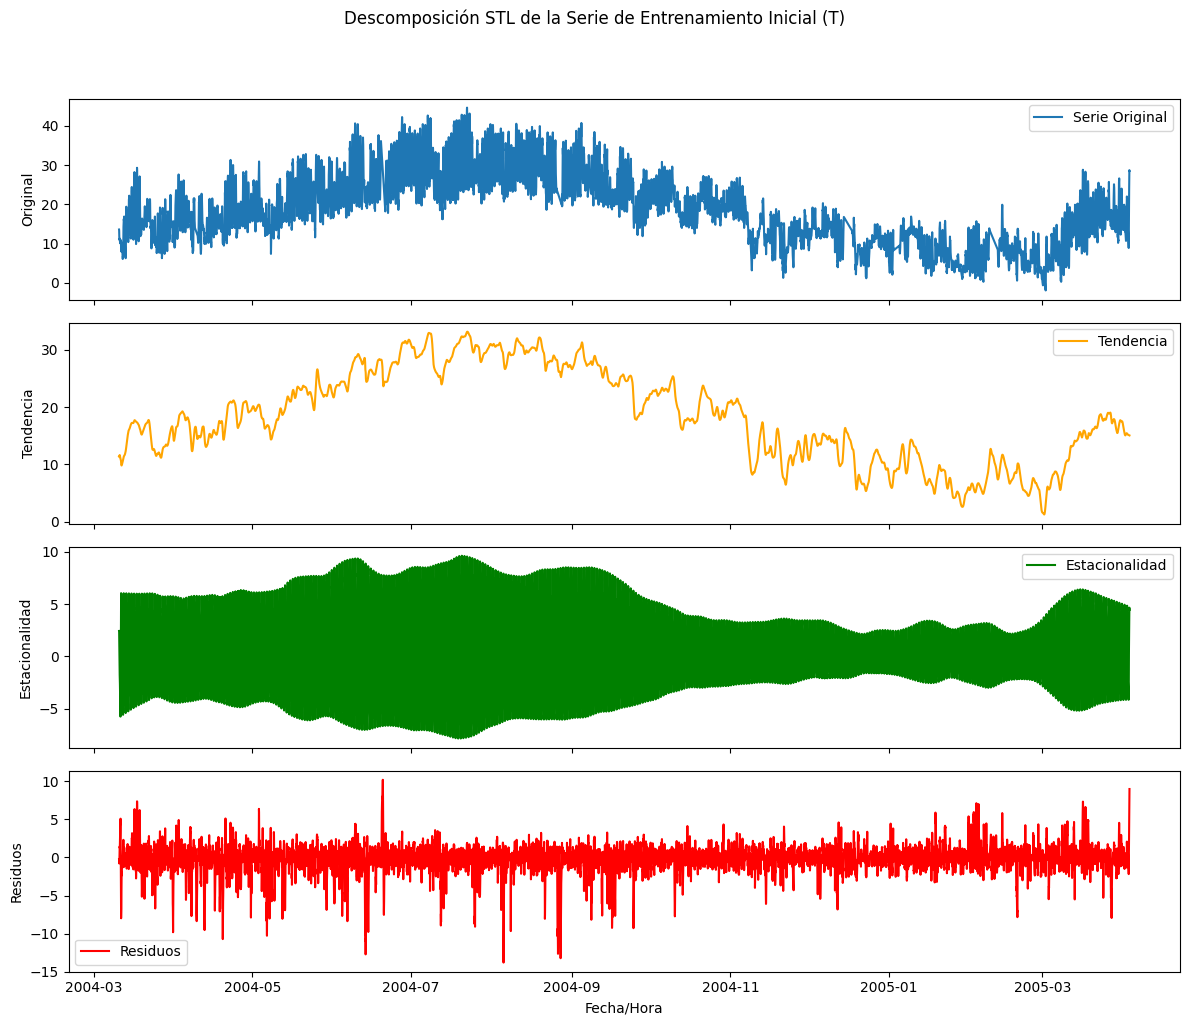


Iniciando proceso de predicción en ventana deslizante...

--- Prediciendo para el punto de prueba 2005-04-03 15:00 (Valor Real: 30.00) ---
  Residuos históricos TOTALES para categorización Mondrian: 9332
  Conteo de residuos por categoría Mondrian (completo):
    Categoría 1: 601 residuos
    Categoría 2: 3977 residuos
    Categoría 3: 1001 residuos
    Categoría 4: 3753 residuos
  Usando los 72 residuos más recientes de la categoría 1 para la estimación de la CDF.
  Media predicha para el valor original: 16.39
  CRPS para este punto: 12.5204

--- Prediciendo para el punto de prueba 2005-04-03 16:00 (Valor Real: 29.40) ---
  Residuos históricos TOTALES para categorización Mondrian: 9333
  Conteo de residuos por categoría Mondrian (completo):
    Categoría 1: 601 residuos
    Categoría 2: 3978 residuos
    Categoría 3: 999 residuos
    Categoría 4: 3755 residuos
  Usando los 72 residuos más recientes de la categoría 1 para la estimación de la CDF.
  Media predicha para el valor origina

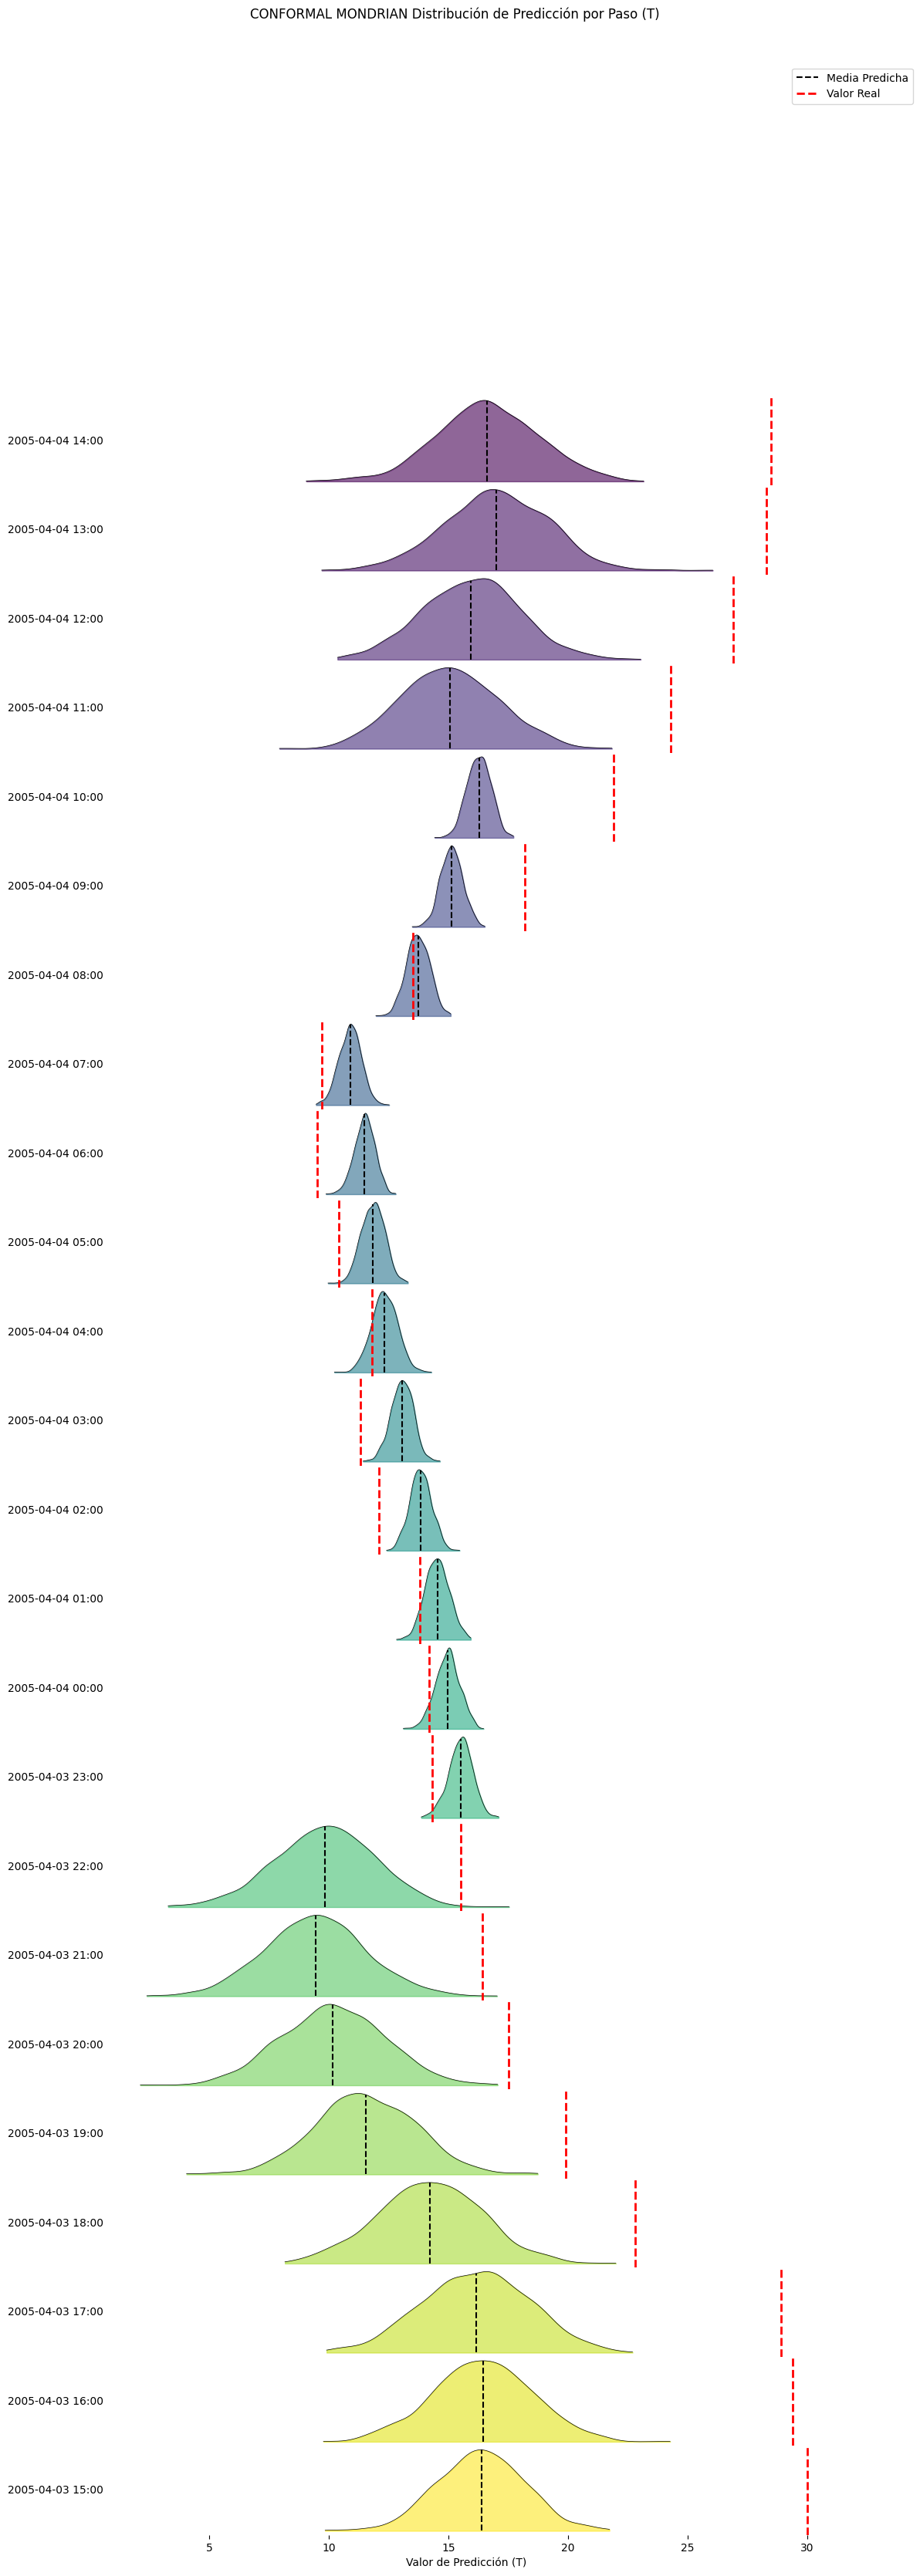


Tabla de Resumen de Predicciones:


,Fecha Predicción,Valor Real,Media Predictiva,CRPS,Cat. Mondrian,Residuo Medio Est.,Residuo Std Est.,Tendencia STL,Estacionalidad STL
0,2005-04-03 15:00,30.0,16.394923,12.520443,1,-3.29,1.92,15.07,4.62
1,2005-04-03 16:00,29.4,16.494221,11.723317,1,-3.40,2.10,15.04,4.85
2,2005-04-03 17:00,28.9,16.203692,11.496711,1,-3.49,2.13,15.01,4.68
3,2005-04-03 18:00,22.8,14.365671,7.224416,1,-3.54,2.14,14.98,2.93
4,2005-04-03 19:00,19.9,11.599209,7.078703,1,-3.98,2.17,14.95,0.63
5,2005-04-03 20:00,17.5,10.091827,6.198033,1,-4.01,2.15,14.91,-0.80
6,2005-04-03 21:00,16.4,9.337225,5.878140,1,-4.04,2.10,14.96,-1.58
7,2005-04-03 22:00,15.5,9.657966,4.673936,1,-3.53,2.08,15.07,-1.89
8,2005-04-03 23:00,14.3,15.478297,0.885443,4,-0.69,0.53,18.20,-2.04
9,2005-04-04 00:00,14.2,14.953851,0.499346,4,-0.73,0.50,17.99,-2.30


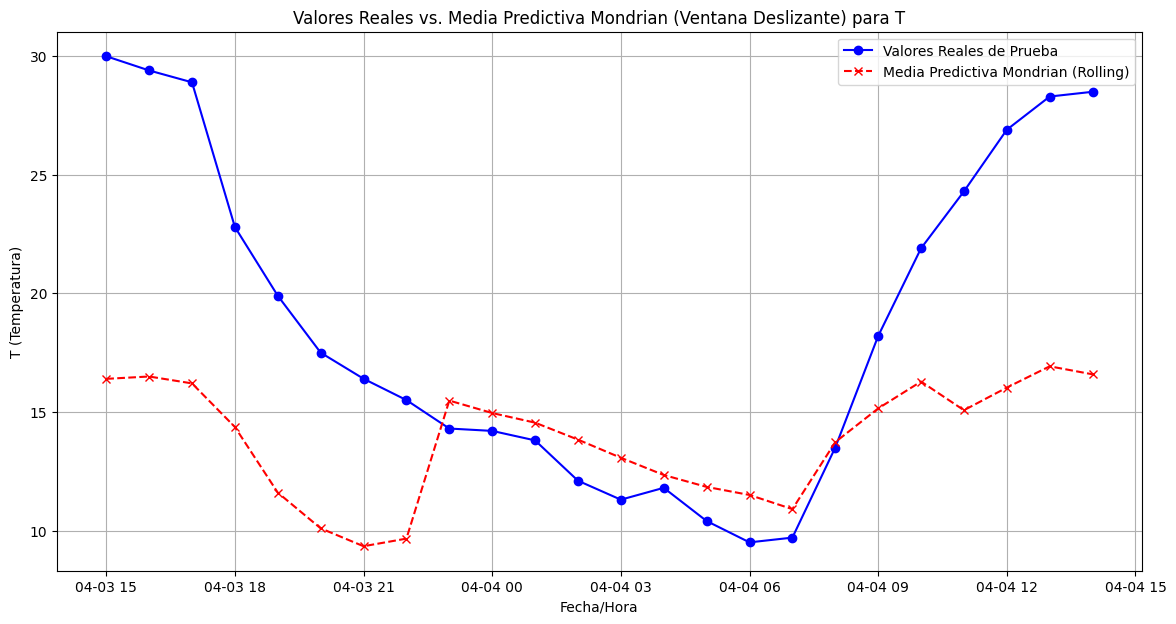

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.stats import uniform, norm, gaussian_kde
import warnings
from typing import Optional, Any

# Suprimir advertencias para una salida más limpia
warnings.filterwarnings("ignore")

# --- Configuración ---
RANDOM_SEED = 10 # Semilla para reproducibilidad
DATA_PATH = "../data/AirQualityUCI.csv" # RUTA DE LA NUEVA BASE DE DATOS
TARGET_COLUMN = 'T' # NUEVA COLUMNA OBJETIVO (Temperatura)
SEASONAL_PERIOD = 24 # Para datos horarios (diarios), el período estacional es 24
N_LAGS_ACF = 40 
N_LAGS_LJUNG_BOX = 10 
N_TEST_POINTS = 24 # Número de últimos puntos para usar como test (un día completo de datos horarios)
N_CANDIDATE_RESIDUALS_FOR_DIST = 200 # Número de puntos para la discretización de la distribución predictiva
N_SAMPLES_FOR_VISUALIZATION = 1000 # Número de muestras a generar para la visualización KDE
# Nuevo: Número de residuos más recientes DENTRO DE LA CATEGORÍA Mondrian para calcular la CDF
N_RESIDUALS_FOR_CDF_WINDOW = 72 # (ej. 3 días de datos horarios para la estimación de la distribución)


# Calcular la longitud de la ventana de suavizado estacional para STL.
# Debe ser un entero impar >= 3.
# Si SEASONAL_PERIOD es par, se le suma 1 para que sea impar.
stl_seasonal_window_length = SEASONAL_PERIOD + 1 if SEASONAL_PERIOD % 2 == 0 else SEASONAL_PERIOD
if stl_seasonal_window_length < 3: # Asegurarse de que sea al menos 3
    stl_seasonal_window_length = 3

# Establecer la semilla global para NumPy
np.random.seed(RANDOM_SEED)

print("Iniciando análisis de Predicción Conformal Mondrian Riguroso con datos reales.")

# 1) Carga de Datos Reales y Preprocesamiento para AirQualityUCI
print(f"\n1) Cargando datos desde {DATA_PATH}...")
try:
    # Usar decimal=',' para corregir el error de conversión de float
    df = pd.read_csv(DATA_PATH, sep=';', decimal=',')
    # Eliminar las últimas dos columnas que suelen estar vacías en este dataset
    df = df.iloc[:, :-2]

    # Combinar 'Date' y 'Time' en un único índice DateTime
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
    df = df.set_index('DateTime')
    df = df.drop(columns=['Date', 'Time'])

    # Reemplazar valores faltantes (-200) por NaN
    df = df.replace(to_replace=-200, value=np.nan)

    series_full = df[TARGET_COLUMN].copy()

    # Interpolar valores faltantes en la serie objetivo
    print(f"Valores faltantes en '{TARGET_COLUMN}' antes de interpolación: {series_full.isnull().sum()}")
    series_full = series_full.interpolate(method='linear')
    # Eliminar cualquier NaN restante al principio o al final que no pudo ser interpolado
    series_full = series_full.dropna()
    print(f"Valores faltantes en '{TARGET_COLUMN}' después de interpolación: {series_full.isnull().sum()}")

    # Asegurarse de que el índice no contenga NaT
    if series_full.index.isnull().any():
        print(f"Advertencia: El índice de la serie contiene {series_full.index.isnull().sum()} NaT. Eliminando estas entradas.")
        series_full = series_full[series_full.index.notnull()]

    print(f"Datos cargados. {len(series_full)} puntos desde {series_full.index.min()} hasta {series_full.index.max()}.")
    print(f"Primeros 5 valores de la serie '{TARGET_COLUMN}':\n{series_full.head()}")
except FileNotFoundError:
    print(f"ERROR: El archivo {DATA_PATH} no se encontró. Asegúrate de que la ruta sea correcta.")
    exit()
except Exception as e:
    print(f"ERROR al cargar o procesar el archivo: {e}")
    exit()

# --- División de datos en entrenamiento y prueba ---
if len(series_full) <= N_TEST_POINTS:
    raise ValueError(f"La serie de tiempo es demasiado corta para {N_TEST_POINTS} puntos de prueba.")
    
series_train_initial = series_full.iloc[:-N_TEST_POINTS]
series_test = series_full.iloc[-N_TEST_POINTS:]

print(f"\nSerie dividida: {len(series_train_initial)} puntos para entrenamiento inicial, {len(series_test)} para prueba.")

# Descomposición STL inicial para obtener los parámetros de la primera STL y para el fallback
res_train = None
residuals_train = pd.Series([], dtype=float)
try:
    # Usar stl_seasonal_window_length para el parámetro 'seasonal' de STL
    stl_initial = STL(series_train_initial, period=SEASONAL_PERIOD, seasonal=stl_seasonal_window_length, robust=True)
    res_train = stl_initial.fit()
    residuals_train = res_train.resid[~np.isnan(res_train.resid)]
    print("\nDescomposición STL inicial exitosa en la serie de entrenamiento.")

    # --- Visualización de la Descomposición STL ---
    print("\nVisualizando la descomposición STL de la serie de entrenamiento inicial:")
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    ax1.plot(series_train_initial, label='Serie Original')
    ax1.set_ylabel('Original')
    ax1.legend()

    ax2.plot(res_train.trend, label='Tendencia', color='orange')
    ax2.set_ylabel('Tendencia')
    ax2.legend()

    ax3.plot(res_train.seasonal, label='Estacionalidad', color='green')
    ax3.set_ylabel('Estacionalidad')
    ax3.legend()

    ax4.plot(res_train.resid, label='Residuos', color='red')
    ax4.set_ylabel('Residuos')
    ax4.legend()

    plt.xlabel('Fecha/Hora')
    plt.suptitle(f'Descomposición STL de la Serie de Entrenamiento Inicial ({TARGET_COLUMN})', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar layout para el título
    plt.show()

except Exception as e:
    print(f"Advertencia: Error en la descomposición STL inicial o en su visualización: {e}. Puede afectar el fallback.")


# --- Funciones de ayuda reutilizables ---

def nonconformity_measure(resid):
    return np.abs(resid)

def get_mondrian_category(prev_resid, threshold):
    is_positive = prev_resid > 0
    is_high_magnitude = np.abs(prev_resid) > threshold

    if is_positive and is_high_magnitude:
        return 1
    elif is_positive and not is_high_magnitude:
        return 2
    elif not is_positive and is_high_magnitude:
        return 3
    else:
        return 4

def calculate_mondrian_cdf_from_residuals(historical_residuals_in_category, magnitude_threshold):
    if len(historical_residuals_in_category) < 2:
        candidate_residuals_range = np.linspace(-15, 15, N_CANDIDATE_RESIDUALS_FOR_DIST)
        return candidate_residuals_range, np.full_like(candidate_residuals_range, 0.5), np.nan, np.nan

    min_hist_res = np.min(historical_residuals_in_category)
    max_hist_res = np.max(historical_residuals_in_category)
    
    if min_hist_res == max_hist_res:
        range_extension = magnitude_threshold * 2 
    else:
        range_extension = (max_hist_res - min_hist_res) * 0.5
    
    candidate_residuals_range = np.linspace(min_hist_res - range_extension, max_hist_res + range_extension, N_CANDIDATE_RESIDUALS_FOR_DIST)

    p_values = []
    historical_scores = np.array([nonconformity_measure(r) for r in historical_residuals_in_category])
    
    for cand_resid in candidate_residuals_range:
        cand_score = nonconformity_measure(cand_resid)
        
        count_greater_than_cand = np.sum(historical_scores > cand_score)
        count_equal_to_cand = np.sum(historical_scores == cand_score)
        
        n_effective_in_category = len(historical_scores) + 1
        current_tau = uniform.rvs(size=1)[0] # Usará la semilla global
        
        smoothed_p_value = (count_greater_than_cand + current_tau * count_equal_to_cand) / n_effective_in_category
        p_values.append(smoothed_p_value)

    sorted_indices = np.argsort(candidate_residuals_range)
    sorted_candidate_residuals = candidate_residuals_range[sorted_indices]
    sorted_p_values = np.array(p_values)[sorted_indices]
    
    for k in range(1, len(sorted_p_values)):
        if sorted_p_values[k] < sorted_p_values[k-1]:
            sorted_p_values[k] = sorted_p_values[k-1]
            
    q25 = np.interp(0.25, sorted_p_values, sorted_candidate_residuals)
    q50 = np.interp(0.50, sorted_p_values, sorted_candidate_residuals)
    q75 = np.interp(0.75, sorted_p_values, sorted_candidate_residuals)

    estimated_mean = q50
    estimated_std = (q75 - q25) / (2 * norm.ppf(0.75)) if (q75 - q25) > 0 else magnitude_threshold

    return sorted_candidate_residuals, sorted_p_values, estimated_mean, estimated_std

def calculate_crps_gaussian(observed_value, mean, std):
    if np.isnan(mean) or np.isnan(std) or std <= 0:
        return np.inf
    
    z = (observed_value - mean) / std
    crps = std * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))
    return crps

# --- Función de visualización adaptada ---
def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame,
                                 model_type: str,
                                 test_data: pd.Series,
                                 bw_method: Optional[Any] = None,
                                 **fig_kw) -> plt.Figure:
    
    index_to_plot = bootstrapping_predictions.index.astype(str).to_list()[::-1] 
    palette = plt.cm.viridis(np.linspace(0, 1, len(index_to_plot)))
    
    fig_kw.pop('test_data', None)
    
    fig, axs = plt.subplots(len(index_to_plot), 1, sharex=True, figsize=(fig_kw.get('figsize', (12, 1.5 * len(index_to_plot)))))
    
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    legend_handles = []
    legend_labels = []

    for i, step in enumerate(index_to_plot):
        samples = bootstrapping_predictions.loc[step, :].dropna()
        
        if len(samples) > 1 and samples.std() > 1e-6:
            kde_func = gaussian_kde(samples, bw_method=bw_method)
            x_values = np.linspace(samples.min() - 0.1 * samples.std(), samples.max() + 0.1 * samples.std(), 500)
            y_values = kde_func(x_values)
            axs[i].plot(x_values, y_values, lw=0.5, color='black')
            axs[i].fill_between(x_values, y_values, color=palette[i], alpha=0.6)
            
            prediction_mean = samples.mean()
            idx = np.abs(x_values - prediction_mean).argmin()
            mean_line = axs[i].vlines(x_values[idx], ymin=0, ymax=y_values[idx], linestyle="dashed", color='black', label='Media Predicha')
        else:
            prediction_mean = samples.mean() if len(samples) > 0 else 0
            mean_line = axs[i].axvline(x=prediction_mean, color='black', linestyle='dashed', linewidth=1, label='Media Predicha (Degenerada)')
            if len(samples) <= 1:
                axs[i].text(prediction_mean, 0.5, 'Distribución Degenerada', transform=axs[i].get_xaxis_transform(), 
                            color='grey', va='center', ha='center', fontsize=8)
        
        real_value = test_data.loc[step]
        actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2, label='Valor Real')
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal', ha='right', va='center')
        if i == len(index_to_plot) - 1:
            axs[i].set_xlabel(f'Valor de Predicción ({TARGET_COLUMN})')
        else:
            axs[i].set_xlabel('')
        
        if i == 0:
            current_handles, current_labels = axs[i].get_legend_handles_labels()
            for handle, label in zip(current_handles, current_labels):
                if label not in legend_labels:
                    legend_handles.append(handle)
                    legend_labels.append(label)

    fig.subplots_adjust(hspace=-0)
    model_title = f"{model_type.upper()} Distribución de Predicción por Paso ({TARGET_COLUMN})"
    fig.suptitle(model_title, y=1.02)
    
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)

    return fig


# --- Proceso principal de ventana deslizante ---
crps_results = []
predicted_values_overview = []
actual_values_overview = []
prediction_times = []
all_prediction_samples = []

mondrian_categories_used = []
estimated_resid_means = []
estimated_resid_stds = []
trend_comps = []
seasonal_comps = []

current_historical_series = series_train_initial.copy()

print("\nIniciando proceso de predicción en ventana deslizante...")
for i in range(N_TEST_POINTS):
    test_point_index = series_test.index[i]
    actual_test_value = series_test.iloc[i]
    prediction_times.append(test_point_index)
    actual_values_overview.append(actual_test_value)

    print(f"\n--- Prediciendo para el punto de prueba {test_point_index.strftime('%Y-%m-%d %H:%M')} (Valor Real: {actual_test_value:.2f}) ---")

    current_trend_comp = np.nan
    current_seasonal_comp = np.nan
    
    if len(current_historical_series) < SEASONAL_PERIOD * 2:
        print("  Advertencia: Serie histórica demasiado corta para STL robusta. Usando descomposición previa o promedios.")
        if res_train is not None and not residuals_train.empty:
            residuals_current = residuals_train.copy()
            current_trend_comp = res_train.trend.iloc[-1]
            current_seasonal_comp = res_train.seasonal.iloc[-SEASONAL_PERIOD]
        else:
            print("  Error: No hay descomposición STL inicial disponible para fallback.")
            residuals_current = current_historical_series - current_historical_series.mean() if len(current_historical_series) > 0 else pd.Series([], dtype=float)
            current_trend_comp = current_historical_series.mean() if len(current_historical_series) > 0 else 0
            current_seasonal_comp = 0
    else:
        stl_current = STL(current_historical_series, period=SEASONAL_PERIOD, seasonal=stl_seasonal_window_length, robust=True)
        res_current = stl_current.fit()
        residuals_current = res_current.resid[~np.isnan(res_current.resid)]
        current_trend_comp = res_current.trend.iloc[-1]
        current_seasonal_comp = res_current.seasonal.iloc[-SEASONAL_PERIOD]

    if len(residuals_current) < 2 or np.isnan(current_trend_comp) or np.isnan(current_seasonal_comp):
        print("  Error: No hay suficientes residuos o componentes STL válidos en la ventana actual. Saltando predicción.")
        crps_results.append(np.inf)
        predicted_values_overview.append(np.nan)
        mondrian_categories_used.append(np.nan)
        estimated_resid_means.append(np.nan)
        estimated_resid_stds.append(np.nan)
        trend_comps.append(np.nan)
        seasonal_comps.append(np.nan)
        all_prediction_samples.append(pd.Series([np.nan] * N_SAMPLES_FOR_VISUALIZATION, name=test_point_index)) 
        current_historical_series = pd.concat([current_historical_series, pd.Series([actual_test_value], index=[test_point_index])])
        continue

    # --- La categorización Mondrian se realiza sobre TODOS los residuos relevantes actuales ---
    magnitude_threshold_current = np.std(residuals_current) # Usamos todos los residuos para este umbral
    if magnitude_threshold_current == 0:
        magnitude_threshold_current = 0.01
        
    categories_current = np.zeros(len(residuals_current), dtype=int)
    # El primer residuo en la serie no tiene 'prev_resid', así que lo marcamos para ignorar
    if len(residuals_current) > 0:
        categories_current[0] = -1 
        for j in range(1, len(residuals_current)):
            prev_resid = residuals_current.iloc[j-1]
            categories_current[j] = get_mondrian_category(prev_resid, magnitude_threshold_current)
    
    # Filtramos los residuos y categorías válidas (donde categories_current no es -1)
    mondrian_residuals_for_categorization = residuals_current[categories_current != -1]
    mondrian_categories_for_categorization = categories_current[categories_current != -1] 

    # Imprimir información de las categorías Mondrian
    if len(mondrian_categories_for_categorization) > 0:
        print(f"  Residuos históricos TOTALES para categorización Mondrian: {len(mondrian_residuals_for_categorization)}")
        category_counts = pd.Series(mondrian_categories_for_categorization).value_counts().sort_index()
        print(f"  Conteo de residuos por categoría Mondrian (completo):")
        for cat, count in category_counts.items():
            print(f"    Categoría {cat}: {count} residuos")
    else:
        print("  Advertencia: No hay suficientes residuos para formar categorías Mondrian en esta ventana.")
        mondrian_categories_used.append(np.nan)
        estimated_resid_means.append(np.nan)
        estimated_resid_stds.append(np.nan)
        crps_results[-1] = np.inf 
        all_prediction_samples.append(pd.Series([np.nan] * N_SAMPLES_FOR_VISUALIZATION, name=test_point_index))
        current_historical_series = pd.concat([current_historical_series, pd.Series([actual_test_value], index=[test_point_index])])
        continue

    last_available_resid_for_category = mondrian_residuals_for_categorization.iloc[-1] if len(mondrian_residuals_for_categorization) > 0 else 0
    next_resid_category = get_mondrian_category(last_available_resid_for_category, magnitude_threshold_current)
    mondrian_categories_used.append(next_resid_category)

    # --- Seleccionar residuos en la categoría predicha ---
    historical_residuals_in_predicted_category = mondrian_residuals_for_categorization[mondrian_categories_for_categorization == next_resid_category]

    # --- Aplicar la ventana rodante para la estimación de la CDF ---
    # Usar solo los N_RESIDUALS_FOR_CDF_WINDOW más recientes de esta categoría
    if len(historical_residuals_in_predicted_category) > N_RESIDUALS_FOR_CDF_WINDOW:
        recent_residuals_for_cdf = historical_residuals_in_predicted_category.iloc[-N_RESIDUALS_FOR_CDF_WINDOW:]
        print(f"  Usando los {N_RESIDUALS_FOR_CDF_WINDOW} residuos más recientes de la categoría {next_resid_category} para la estimación de la CDF.")
    else:
        recent_residuals_for_cdf = historical_residuals_in_predicted_category
        print(f"  Usando TODOS los {len(recent_residuals_for_cdf)} residuos de la categoría {next_resid_category} para la estimación de la CDF (menos de {N_RESIDUALS_FOR_CDF_WINDOW}).")
    
    if len(recent_residuals_for_cdf) < 2:
        print(f"  Advertencia: Demasiados pocos residuos ({len(recent_residuals_for_cdf)}) en la categoría Mondrian seleccionada para estimar la CDF. Saltando predicción de este paso.")
        estimated_resid_means.append(np.nan)
        estimated_resid_stds.append(np.nan)
        crps_results[-1] = np.inf 
        predicted_values_overview[-1] = np.nan # También actualizamos la media predictiva si no se pudo calcular
        all_prediction_samples.append(pd.Series([np.nan] * N_SAMPLES_FOR_VISUALIZATION, name=test_point_index))
        current_historical_series = pd.concat([current_historical_series, pd.Series([actual_test_value], index=[test_point_index])])
        continue


    cdf_x_resid, cdf_y_resid, estimated_mean_resid, estimated_std_resid = \
        calculate_mondrian_cdf_from_residuals(recent_residuals_for_cdf, magnitude_threshold_current)

    if np.isnan(estimated_mean_resid):
        estimated_mean_resid = np.mean(recent_residuals_for_cdf) if len(recent_residuals_for_cdf) > 0 else 0
        estimated_std_resid = np.std(recent_residuals_for_cdf) if len(recent_residuals_for_cdf) > 1 else magnitude_threshold_current
        if estimated_std_resid <=0 : estimated_std_resid = magnitude_threshold_current
    
    estimated_resid_means.append(estimated_mean_resid)
    estimated_resid_stds.append(estimated_std_resid)
    trend_comps.append(current_trend_comp)
    seasonal_comps.append(current_seasonal_comp)

    predicted_original_mean = estimated_mean_resid + current_trend_comp + current_seasonal_comp
    predicted_original_std = estimated_std_resid

    current_crps = calculate_crps_gaussian(actual_test_value, predicted_original_mean, predicted_original_std)
    crps_results.append(current_crps)
    predicted_values_overview.append(predicted_original_mean)

    print(f"  Media predicha para el valor original: {predicted_original_mean:.2f}")
    print(f"  CRPS para este punto: {current_crps:.4f}")

    if predicted_original_std > 0:
        samples_for_step = norm.rvs(loc=predicted_original_mean, scale=predicted_original_std, size=N_SAMPLES_FOR_VISUALIZATION)
    else:
        samples_for_step = np.full(N_SAMPLES_FOR_VISUALIZATION, predicted_original_mean)
        
    all_prediction_samples.append(pd.Series(samples_for_step, name=test_point_index))
    
    current_historical_series = pd.concat([current_historical_series, pd.Series([actual_test_value], index=[test_point_index])])


# --- Resumen Final ---
print("\n--- RESUMEN FINAL DE PREDICCIONES EN EL CONJUNTO DE PRUEBA ---")
print(f"CRPS Promedio en el conjunto de prueba ({N_TEST_POINTS} puntos): {np.nanmean(crps_results):.4f}")

# Convertir la lista de Series de muestras a un DataFrame para la función de visualización
bootstrapping_predictions_df = pd.DataFrame(all_prediction_samples).T 
bootstrapping_predictions_df.columns = [col.strftime('%Y-%m-%d %H:%M') for col in bootstrapping_predictions_df.columns]
bootstrapping_predictions_df.index = [f'sample_{k}' for k in range(bootstrapping_predictions_df.shape[0])]
bootstrapping_predictions_df = bootstrapping_predictions_df.T 

# Ajustar el índice de test_data para que coincida con el formato de string en bootstrapping_predictions_df
test_data_for_plot = series_test[prediction_times].rename(index=lambda x: x.strftime('%Y-%m-%d %H:%M'))

# Llamar a la función de visualización con los datos recolectados
fig_dist = plot_prediction_distribution(
    bootstrapping_predictions=bootstrapping_predictions_df,
    model_type="Conformal Mondrian",
    test_data=test_data_for_plot,
    figsize=(12, 1.5 * N_TEST_POINTS)
)
plt.show()

# Crear la tabla resumen de resultados
summary_data = {
    'Fecha Predicción': [d.strftime('%Y-%m-%d %H:%M') for d in prediction_times],
    'Valor Real': actual_values_overview,
    'Media Predictiva': predicted_values_overview,
    'CRPS': crps_results,
    'Cat. Mondrian': mondrian_categories_used,
    'Residuo Medio Est.': ['{:.2f}'.format(m) if not np.isnan(m) else 'N/A' for m in estimated_resid_means],
    'Residuo Std Est.': ['{:.2f}'.format(s) if not np.isnan(s) else 'N/A' for s in estimated_resid_stds],
    'Tendencia STL': ['{:.2f}'.format(t) if not np.isnan(t) else 'N/A' for t in trend_comps],
    'Estacionalidad STL': ['{:.2f}'.format(s) if not np.isnan(s) else 'N/A' for s in seasonal_comps],
}

summary_df = pd.DataFrame(summary_data)
print("\nTabla de Resumen de Predicciones:")
display(summary_df)

# Gráfico de resumen de valores reales vs. media predictiva
plt.figure(figsize=(14, 7))
plt.plot(prediction_times, actual_values_overview, marker='o', linestyle='-', color='blue', label='Valores Reales de Prueba')
plt.plot(prediction_times, predicted_values_overview, marker='x', linestyle='--', color='red', label='Media Predictiva Mondrian (Rolling)')
plt.title(f'Valores Reales vs. Media Predictiva Mondrian (Ventana Deslizante) para {TARGET_COLUMN}')
plt.xlabel('Fecha/Hora')
plt.ylabel(f'{TARGET_COLUMN} (Temperatura)')
plt.legend()
plt.grid(True)
plt.show()